In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.patches import Patch
import os
from pathlib import Path
import torch

# import sys to enable relative imports
import sys; sys.path.insert(0, '..')
from params.load_params import LoadParams
from models import create_model

# Define constants

In [2]:
# determine which CpG sites are promising biomarkers according to literature
# usually, only the gene name whose CpG site is differentially methylated is given, such that they have to be determined from the illumina
# support file
def literature_dna_methylation_sites():
    METHYLATED_GENES = {'CDKN2A', 'CHFR', 'EVL', 'IGFBP3', 'IGF2', 'LINE-1', 'MGMT', 'PD-L1', 'QKI', 'RET', 'TFAP2E', 
                        'p14ARF', 'RASSF1A', 'APC1A', 'SRBC', 'PDCH10', 'SPARC', 'UCHL1', 'APC', 'RASSF2A', 'WIF-1',
                        'AKR1B1', 'SEPT9', 'AXIN2', 'BMP3', 'CDH1', 'CMTM3', 'MDFI', 'SSTR2', 'CNRIP1', 'FBN1', 'INA',
                        'MAL', 'SNCA', 'SPG20', 'DAPK', 'DKK3', 'FBNI', 'HLTF', 'hMLH1', 'LKB1', 'LMX1A', 'SOX1',
                        'ZNF177', 'NDRG4', 'NKX6.1', 'p14', 'RARB2', 'SFRP1', 'SFRP2', 'SFRP4', 'SFRP5', 'SNCA', 'SOX1',
                        'STK33', 'TFPI2', 'VIM', 'WIF-1', 'H19'
                       }
    REGEX = f'^(\w*;)*({"|".join(METHYLATED_GENES)})(;\w*)*$'
    # read the human methylation file
    illumina_methylation_info = pd.read_csv('humanmethylation450_15017482_v1-2.csv', sep=',', header=7)
    # filter by regex
    return {*illumina_methylation_info.loc[illumina_methylation_info.UCSC_RefGene_Name.str.contains(REGEX, na=False), 'IlmnID'].values}

<>:12: SyntaxWarning: invalid escape sequence '\w'
<>:12: SyntaxWarning: invalid escape sequence '\w'
<>:12: SyntaxWarning: invalid escape sequence '\w'
<>:12: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_417966/2615699301.py:12: SyntaxWarning: invalid escape sequence '\w'
  REGEX = f'^(\w*;)*({"|".join(METHYLATED_GENES)})(;\w*)*$'
/tmp/ipykernel_417966/2615699301.py:12: SyntaxWarning: invalid escape sequence '\w'
  REGEX = f'^(\w*;)*({"|".join(METHYLATED_GENES)})(;\w*)*$'


In [3]:
len(literature_dna_methylation_sites())

/tmp/ipykernel_417966/2615699301.py:14: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  illumina_methylation_info = pd.read_csv('humanmethylation450_15017482_v1-2.csv', sep=',', header=7)
/tmp/ipykernel_417966/2615699301.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  return {*illumina_methylation_info.loc[illumina_methylation_info.UCSC_RefGene_Name.str.contains(REGEX, na=False), 'IlmnID'].values}


1462

In [69]:
METRICS = ['accuracy', 'precision', 'recall', 'f1-score', 'auc']
OMICS = ['Gene_Expression', 'DNA_Methylation', 'miRNA_Expression', 'lncRNA_Expression']
EXPERIMENTS = ['all_cancer_v05', 'log_all_cancer_v05', 'coad_normal_v05', 'log_coad_normal_v05']
ALL_CANCERS_FILE_PATTERN = 'all_cancer_classification_v05_[0-9]*'
COAD_NORMAL_FILE_PATTERN = 'coad_normal_classification_v05_[0-9]*'
LOG_ALL_CANCERS_FILE_PATTERN = 'all_cancer_classification_log_v05_[0-9]*'
LOG_COAD_NORMAL_FILE_PATTERN = 'coad_normal_classification_log_v05_[0-9]*'
MOFA_CANDIDATE_FTRS = {
    'miRNA_Expression': {f'hsa-mir-{mir}' for mir in [143, 21, 192, '148a', '10a', '10b', 22]},
    'lncRNA_Expression': {f'ENSG00000{lncrna}' for lncrna in [266402, 242861, 225733, 272141, 
                                                              276107, 229005, 274093, 230590, 228886, 269902]},
    'DNA_Methylation': {f'cg{met}' for met in ['00733780', 18286501, 18240143, 13031210, 22884656, 14192291, '03501539', 
                                               14591667, 12866112, 21554895, '08911368', 17861863, 22740796, '05364038',
                                               25516742, 17714703, '07889936', 20737909, 15470102, 26472036, 21983484,
                                               14804181, 13574945, 11673471, 23696472]},
    'Gene_Expression': set()
}
LITERATURE_FTRS = {
    'miRNA_Expression': {f'hsa-mir-{mir}' for mir in [143, 21, 192, '148a', '10a', '10b', 22, 145, 194, '200b', '200c', '26a', 375, 
                                                      31, '34a', 224, '92a', '20a', 182, 155, 194, 32, '181b', '193b', 195, 411,
                                                      1296, '135b', 539, 572, 185, '21-5p', '20a-5p', '103a-3p', '106-5p', '143-5p',
                                                      215, 93, 195, 141, 494, '125b', '126-3p', '99a', '125b', 16, 153, '590-5p']},
    'lncRNA_Expression': {f'ENSG00000{lncrna}' for lncrna in [228630, 130600, 285793, 239445, 214548, 280837, 273032, 240990, 249510, 
                                                              246985, 255737, 278910, 262117, 246627, 249395, 226950, 176124, 231764, 
                                                              206195, 235123, 233893, 230316, 260944, 237424, 230590, 130600, 226363,
                                                              206337, 258667, 267690, 233532, 245526, 227036, 251562, 245532, 247809,
                                                              253438, 248959, 232803, 255717, 242125, 203875, 245910, 233016, 197989,
                                                              232956, 261183, 204832, 214049, 229807, 237036, 177410, 266402, 225733,
                                                              272141, 228886]},
    'DNA_Methylation': literature_dna_methylation_sites(),
    'Gene_Expression': set()
}
# add mir 7 whose identity is mir-let-7
LITERATURE_FTRS['miRNA_Expression'] = LITERATURE_FTRS['miRNA_Expression'] | set([f'hsa-let-{mir}' for mir in [7, '7b', '7g', '7c']])
JOINT_FTRS = {
    omic: MOFA_CANDIDATE_FTRS[omic] & LITERATURE_FTRS[omic] for omic in OMICS
}

/tmp/ipykernel_417966/2615699301.py:14: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  illumina_methylation_info = pd.read_csv('humanmethylation450_15017482_v1-2.csv', sep=',', header=7)
/tmp/ipykernel_417966/2615699301.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  return {*illumina_methylation_info.loc[illumina_methylation_info.UCSC_RefGene_Name.str.contains(REGEX, na=False), 'IlmnID'].values}


### Blood, stool and urine specific biomarkers

In [5]:
# this is a list of genes which was addtionally observed to be a biomarker in CRC in Stool, blood, or urine probes
# It is not used, but can be relevant for future studies
METHYLATED_GENES_STOOL = {'ALX4', 'CDKN2A', 'GATA4', 'HPP1', 'HTLF', 'ITG4', 'LINE-1', 'MGMT', 'MLH1', 'NDRG4', 'NEUROG1',
                        'NGFR', 'OSMR', 'PHACTR3', 'RASSF2', 'SDG2', 'SEPT9', 'SFRP2', 'TFPI2', 'TMEFF2', 'WIF1', 'APC',
                        'RASSF2A', 'SFRP1', 'SDC2', 'PRIMA1', 'CYCD2', 'HIC1', 'PAX5', 'RASSF1A', 'RB1', 'SRBC', 
                        'TMEFF2', 'BMP3', 'NPTX2', 'RARB', 'VIM', 'TFPI2', 'GATA5', 'ITGA4', 'p16', 'CHFR', 'EVL', 'HLTF',
                        'HPP1', 'IHFBP3', 'IGF2', 'PD-L1', 'QKI', 'RET', 'SST', 'TFAP2E', 'PCDH10', 'SPARC', 'UCHL1',
                        'AKR1B1', 'AXIN2', 'CDH1', 'BCAT1', 'IKZF1', 'C9orf50', 'CLIP4', 'KCNQ5', 'KCNJ12', 'ZNF132', 'TWIST1', 'CYCD2', 'EFHD1',
                        'PPP1R3C', 'FOXE1', 'SYNE1', 'MDG1', 'HLTF', 'hMLH1', 'NPY', 'PENK', 'PRIMA1', 'RUNX3', 'TAC1'}
MIRNA_STOOL = {'92a', '29a', '20a', '106a', 223, 221, '135b', 31, '125b', 601, 760, '181b',
                203, '19a', '19b', '15a', 135, '422a', 532, 331, 195, 17, 142, '15b', 652,
                '34a', 224, 182, 155, 32, '193b', 411, 1296, 539, 572, 185, '103a', '106b',
                215, 103, '320a', 451, 596, 93, 141, 494, '19a-3p', '223-3p', '92a-3p', '532-3p',
                '142-3p', '103a-3p', '106b-5p', '143-5p', '126-3p', '590-5p', 153, 130, 216,
                372
              }
LNCRNA_STOOL = {}

# OmiEmbed Performance metrics

In [6]:
# tail function to get the last line of the train summary. This line contains the test statistics of the last epoch
def tail(f, lines=1, _buffer=4098):
    """Tail a file and get X lines from the end"""
    # place holder for the lines found
    lines_found = []

    # block counter will be multiplied by buffer
    # to get the block size from the end
    block_counter = -1

    # loop until we find X lines
    while len(lines_found) < lines:
        try:
            f.seek(block_counter * _buffer, os.SEEK_END)
        except IOError:  # either file is too small, or too many lines requested
            f.seek(0)
            lines_found = f.readlines()
            break

        lines_found = f.readlines()

        # decrement the block counter to get the
        # next X bytes
        block_counter -= 1

    return lines_found[-lines:]

## Import necessary data

In [7]:
# function to import the train and test statistic for all runs performed with OmiEmbed
def import_train_test_statistics(file_pattern: str):
    # define the dcitionaries to be returned
    train_stats = {metric: [] for metric in METRICS}
    test_stats = {metric: [] for metric in METRICS}
    for directory in Path('../checkpoints/').glob(file_pattern):
        # read the last line of the train file, which contains the metrics of the last epoch
        # and get the last len(METRICS) entries, which contain the necessary metrics values
        train_file = os.path.join(directory, 'train_summary.txt')
        loaded_train_stats = tail(open(train_file, 'r'))[0].strip().split('\t')[-len(METRICS):]
        # read the last line of the test file, which contains the metrics of the last epoch
        # and get the last len(METRICS) entries, which contain the necessary metrics values
        test_file = os.path.join(directory, 'test_summary.txt')
        loaded_test_stats = tail(open(test_file, 'r'))[0].strip().split('\t')[-len(METRICS):]
        # store the metrics
        for i in range(len(METRICS)):
            train_stats[METRICS[i]].append(float(loaded_train_stats[i]))
            test_stats[METRICS[i]].append(float(loaded_test_stats[i]))
    return train_stats, test_stats

In [8]:
# load the data for the experiments
all_cancers_train_stats, all_cancers_test_stats = import_train_test_statistics(ALL_CANCERS_FILE_PATTERN)
coad_normal_train_stats, coad_normal_test_stats = import_train_test_statistics(COAD_NORMAL_FILE_PATTERN)
log_all_cancers_train_stats, log_all_cancers_test_stats = import_train_test_statistics(LOG_ALL_CANCERS_FILE_PATTERN)
log_coad_normal_train_stats, log_coad_normal_test_stats = import_train_test_statistics(LOG_COAD_NORMAL_FILE_PATTERN)

In [9]:
# Load the clinical data
def load_clinical_data(clinical_file: str):
    clinical_data = pd.read_csv(os.path.join('..', 'data', clinical_file), sep='\t')
    coad_samples = clinical_data.loc[clinical_data['Tumor'] == 'COAD', 'Barcode']
    cancer_codes = clinical_data.loc[:, ['Tumor', 'Tumor_codes']].drop_duplicates()
    cancer_codes = {cancer_codes.loc[idx, 'Tumor']: cancer_codes.loc[idx, 'Tumor_codes'] for idx in cancer_codes.index}
    return clinical_data, cancer_codes

all_cancer_clinical, all_cancer_cancer_codes = load_clinical_data('clinical.tsv')
coad_normal_clinical, coad_normal_cancer_codes = load_clinical_data('clinical_coad_normal.tsv')

In [10]:
# load the raw input data for OmiEmbed
omics_dfs = []
for omic in 'ABCD':
    print(f'Reading file {omic}.tsv')
    file_path = os.path.join('..', 'data', f'{omic.upper()}.tsv')
    raw_omics_data = pd.read_csv(file_path, sep='\t', header=0, index_col=0, na_filter=True)
    # raw_omics_data = raw_omics_data.loc[:, clinical_data.Barcode.values]
    omics_dfs.append(raw_omics_data)
omics_dfs

Reading file A.tsv
Reading file B.tsv
Reading file C.tsv
Reading file D.tsv


[                 TCGA-13-A5FT-01A  TCGA-5X-AA5U-01A  TCGA-59-A5PD-01A  \
 Gene                                                                    
 ENSG00000000003           19.0351           13.8773           19.4585   
 ENSG00000000005            0.0103            0.0179            0.0000   
 ENSG00000000419           49.4028           34.8372           48.1802   
 ENSG00000000457            1.5955            4.1998            1.2863   
 ENSG00000000460            1.5760            4.1305            1.8197   
 ...                           ...               ...               ...   
 ENSG00000288611            0.0073            0.0094            0.0169   
 ENSG00000288617            0.0093            0.0000            0.0087   
 ENSG00000288658            1.2458            0.4224            0.7688   
 ENSG00000288660            1.1345            3.1578            6.5303   
 ENSG00000288675            0.1636            0.2906            0.4667   
 
                  TCGA-OY-A56P-01A  

In [11]:
# write the dictionary OmiEmbed needs to initialize the values
def write_omiembed_init_dict(clinical_data, log_transform = False):
    if log_transform:
        for omic in [0,1,3]:
            omics_dfs[omic] = np.log2(omics_dfs[omic] + 1)
    omics_tensors = [torch.Tensor(omics_df.loc[:, clinical_data.Barcode.values].fillna(0).T.values.astype('float32')).to('cpu') for omics_df in omics_dfs]
    init_dict = {
        'index': clinical_data.Barcode.values,
        'input_omics': omics_tensors,
        'label': torch.Tensor(clinical_data.Tumor_codes.values).long()
    }
    return init_dict

# all_cancer_init_dict = write_omiembed_init_dict(all_cancer_clinical, False)
# coad_normal_init_dict = write_omiembed_init_dict(coad_normal_clinical, False)
log_all_cancer_init_dict = write_omiembed_init_dict(all_cancer_clinical, True)
log_coad_normal_init_dict = write_omiembed_init_dict(coad_normal_clinical, True)

## Performance metrics of the model in general

In [12]:
# write the average of the train and test statistics
def write_average_train_and_statistics(experiment, train_stats, test_stats, outfile_prefix):    
    outfile = f'{outfile_prefix}_performance_stats.tsv'
    train_df = pl.DataFrame({metric: [np.array(train_stats[metric]).mean().round(6)] for metric in METRICS})
    test_df = pl.DataFrame({metric: [np.array(test_stats[metric]).mean().round(6)] for metric in METRICS})    
    print(f'\nAverage train metrics for all 20 runs of experiment {experiment}')
    print(train_df)
    print(f'\nAverage test metrics for all 20 runs of experiment {experiment}')
    print(test_df)
    train_df.write_csv(outfile, separator='\t')
    with open(outfile, 'a') as f:
        test_df.write_csv(f, separator='\t', include_header=False)

In [13]:
# write_average_train_and_statistics('all_cancer_classification', all_cancers_train_stats, all_cancers_test_stats, 'all_cancer_v05_without_27k')
# write_average_train_and_statistics('coad_normal_classification', coad_normal_train_stats, coad_normal_test_stats, 'coad_normal_v05_without_27k')
write_average_train_and_statistics('log_all_cancer_classification', log_all_cancers_train_stats, log_all_cancers_test_stats, 'log_all_cancer_v05_without_27k')
write_average_train_and_statistics('log_coad_normal_classification', log_coad_normal_train_stats, log_coad_normal_test_stats, 'log_coad_normal_v05_without_27k')


Average train metrics for all 20 runs of experiment log_all_cancer_classification
shape: (1, 5)
┌──────────┬───────────┬──────────┬──────────┬──────────┐
│ accuracy ┆ precision ┆ recall   ┆ f1-score ┆ auc      │
│ ---      ┆ ---       ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64       ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪═══════════╪══════════╪══════════╪══════════╡
│ 0.994989 ┆ 0.96503   ┆ 0.952064 ┆ 0.955872 ┆ 0.999924 │
└──────────┴───────────┴──────────┴──────────┴──────────┘

Average test metrics for all 20 runs of experiment log_all_cancer_classification
shape: (1, 5)
┌──────────┬───────────┬─────────┬──────────┬──────────┐
│ accuracy ┆ precision ┆ recall  ┆ f1-score ┆ auc      │
│ ---      ┆ ---       ┆ ---     ┆ ---      ┆ ---      │
│ f64      ┆ f64       ┆ f64     ┆ f64      ┆ f64      │
╞══════════╪═══════════╪═════════╪══════════╪══════════╡
│ 0.951442 ┆ 0.90471   ┆ 0.88654 ┆ 0.891648 ┆ 0.997663 │
└──────────┴───────────┴─────────┴──────────┴──────────┘

A

## Performance classifying COAD

In [14]:
# class performance analysis, only written for COAD
# Initialize the model trained by OmiEmbed
def load_model(model_to_load, epochs, classes, init_dict):
    # load the parameters to instanciate the model
    param_loader = LoadParams(model_to_load, epochs, classes, '../checkpoints', False)
    param_loader.set_omics_dims(omics_dfs)
    param = param_loader.get_params()
    # instanciate the model
    model = create_model(param)
    model.setup(param)
    model.set_input(init_dict)
    return model

In [15]:
def cancer_type_metrics(model, cancer_type: int, experiment: str):
    # get the predicted and true classified label from the model output
    values = (model.get_down_output()['y_pred'], model.get_down_output()['y_true'])
    # filter by the labels which have a true label of the cancer_type
    true_label_mask = values[1] == cancer_type
    pred_label_mask = values[0] == cancer_type
    true_cancer_type_indices = torch.nonzero(true_label_mask)
    pred_cancer_type_indices = torch.nonzero(pred_label_mask)
    # use the mask to filter by true labels and predicted labels
    true_label_values = (values[0][true_cancer_type_indices], values[1][true_label_mask])
    pred_label_values = (values[0][pred_cancer_type_indices], values[1][pred_label_mask])
    # count the true positives, i.e. all values that were correctly predicted as cancer_type,
    # and the false negatives, i.e. all values that are cancer_type, but were predicted wrongly
    true_positive = 0
    false_negative = len(true_label_values[0])
    for i in range(len(true_label_values[0])):
        correct_pred = int(true_label_values[0][i] == true_label_values[1][i])
        true_positive += correct_pred
        false_negative -= correct_pred
    # count the false positives
    false_positive = 0
    for i in range(len(pred_label_values[0])):
        false_positive += int(pred_label_values[0][i] != pred_label_values[1][i])
    # calculate the metrics accuracy, precision, recall and f1 score
    accuracy = true_positive / len(true_label_values[0]) * 100
    precision = true_positive / (true_positive + false_positive) * 100
    recall = true_positive / (true_positive + false_negative) * 100
    f1 = 2 * precision * recall / (precision + recall)
    # print the output
    print(f'\nMetrics of cancer with code {cancer_type} for model {experiment} \n')
    print('-' * 49)
    print(f'| ACCURACY\t|\t{accuracy} %\t|')
    print(f'| PRECISION\t|\t{precision} %\t|')
    print(f'| RECALL\t|\t{recall} %\t|')
    print(f'| F1-SCORE\t|\t{f1} %\t|')
    print('-' * 49)
    return accuracy, precision, recall, f1

In [16]:
def print_average_metrics(metrics: dict, experiment: str, cancer_code):
    print(f'\nMetrics of cancer with code {cancer_code} for model {experiment} \n')
    print('-' * 49)
    for metric in metrics.keys():
        print(f'| {metric.upper()}\t|\t{(np.array(metrics[metric]).mean())}%\t|')
    print('-' * 49)

In [17]:
# iterate over all models for each experiment to calculate the average metrics
# the models cannot be loaded at the same time due to a high number needed RAM, which would cause the notebook to crash
def calculate_metrics_for_all_runs(file_pattern, epochs, classes, cancer_type, init_dict):
    # dictionary to save the statistics; the AUC is not given
    all_metrics = {metric: [] for metric in METRICS}
    # begin the calculation
    for f in Path('../checkpoints').glob(file_pattern):
        model = load_model(f.name, epochs, classes, init_dict)
        model.phase = 'p3'
        print(f'Perform the forward step for experiment {f.name}')
        model.forward()
        model.calculate_current_metrics(model.get_down_output())
        metrics = cancer_type_metrics(model, cancer_type, f.name)
        for i in range(len(metrics)):
            all_metrics[METRICS[i]] = metrics[i]
    return all_metrics

In [18]:
"""
# calculate the metrics for classifying COAD and print them
all_cancer_metrics = calculate_metrics_for_all_runs(ALL_CANCERS_FILE_PATTERN, 240, 33, all_cancer_cancer_codes['COAD'], all_cancer_init_dict)
coad_normal_metrics = calculate_metrics_for_all_runs(COAD_NORMAL_FILE_PATTERN, 60, 2, coad_normal_cancer_codes['COAD'], coad_normal_init_dict)
"""
log_all_cancer_metrics = calculate_metrics_for_all_runs(LOG_ALL_CANCERS_FILE_PATTERN, 100, 33, all_cancer_cancer_codes['COAD'], log_all_cancer_init_dict)
log_coad_normal_metrics = calculate_metrics_for_all_runs(LOG_COAD_NORMAL_FILE_PATTERN, 4, 2, coad_normal_cancer_codes['COAD'], log_coad_normal_init_dict)

Initialize network with normal
Initialize network with normal
Model [VaeClassifierModel] was created

----------------------Networks Information----------------------
FcVaeABCD(
  (encode_fc_1B): FCBlock(
    (fc_block): Sequential(
      (0): Linear(in_features=25373, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (encode_fc_1A): FCBlock(
    (fc_block): Sequential(
      (0): Linear(in_features=25836, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (encode_fc_1C): FCBlock(
    (fc_block): Sequential(
      (0): Linear(in_features=932, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine

In [19]:

print_average_metrics(log_all_cancer_metrics, 'all_cancer_classification', all_cancer_cancer_codes['COAD'])
print_average_metrics(log_coad_normal_metrics, 'coad_normal_classification', coad_normal_cancer_codes['COAD'])



Metrics of cancer with code 23 for model all_cancer_classification 

-------------------------------------------------
| ACCURACY	|	99.33554817275747%	|
| PRECISION	|	96.76375404530745%	|
| RECALL	|	99.33554817275747%	|
| F1-SCORE	|	98.03278688524591%	|
| AUC	|	nan%	|
-------------------------------------------------

Metrics of cancer with code 1 for model coad_normal_classification 

-------------------------------------------------
| ACCURACY	|	100.0%	|
| PRECISION	|	98.36601307189542%	|
| RECALL	|	100.0%	|
| F1-SCORE	|	99.17627677100495%	|
| AUC	|	nan%	|
-------------------------------------------------


/tmp/ipykernel_3241631/2291969517.py:5: RuntimeWarning: Mean of empty slice.
  print(f'| {metric.upper()}\t|\t{(np.array(metrics[metric]).mean())}%\t|')
/home/g48r1el/.pyenv/versions/3.13.3/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Performance classifying the other cancers

In [20]:
# Commented due to lack of memory issues. Use it if your device has enough RAM to run this code
"""
cancer_metrics = {}
for key in all_cancer_cancer_codes.keys():
    cancer_metrics[key] = calculate_metrics_for_all_runs(ALL_CANCERS_FILE_PATTERN, 240, 33, all_cancer_cancer_codes[key], all_cancer_init_dict)
"""    

'\ncancer_metrics = {}\nfor key in all_cancer_cancer_codes.keys():\n    cancer_metrics[key] = calculate_metrics_for_all_runs(ALL_CANCERS_FILE_PATTERN, 240, 33, all_cancer_cancer_codes[key], all_cancer_init_dict)\n'

In [21]:
"""
for key in cancer_metrics.keys():
    print_average_metrics(all_cancer_metrics, 'all_cancer_classification', all_cancer_cancer_codes[key])
"""

"\nfor key in cancer_metrics.keys():\n    print_average_metrics(all_cancer_metrics, 'all_cancer_classification', all_cancer_cancer_codes[key])\n"

## Plot the performance metrics

In [199]:
def create_performance_plot(df: pl.DataFrame, outfile):
    cmap = colormaps['tab20']
    col_width = 0.2
    x = range(len(df.columns))
    offsets = [-0.1 - col_width, -0.1, 0.1, 0.1 + col_width]
    counter = 0
    fontsize = 16
    # define the important labels for the legend and the x ticks
    legend_labels = [exper.replace('v05', 'Class').replace('_', ' ').title() for exper in EXPERIMENTS]
    xtick_labels = [tick.title() for tick in df.columns]
    xtick_labels[-1] = xtick_labels[-1].upper()
    # create the bars
    fig, ax = plt.subplots()
    fig.set_figwidth(28)
    fig.set_figheight(8)
    for row in df.rows():
        x_bar = [pos + offsets[counter] for pos in x]
        bars = ax.bar(x_bar, row, width=col_width, label=legend_labels[counter], color=cmap(counter))
        # plt.errorbar()
        plt.bar_label(bars, row, fontsize=fontsize)
        counter += 1
    ax.set_ylim(0.7, 1.07)
    ax.set_xlabel('Performance Metric')
    ax.set_xticks(x, xtick_labels)
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.set_yticks(np.arange(0.7, 1, step=0.1))
    plt.gca().spines['top'].set_visible(False)
    plt.legend(loc='upper center', ncol=len(df), fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(outfile)
    plt.show()

In [200]:
# plot the metrics
def plot_performance_metrics(experiments: list):
    # initialize a dictionary with the average train and test statistics
    stats = {
             'train': pl.DataFrame(data=None, schema={metric: pl.Float64 for metric in METRICS}),
             'test': pl.DataFrame(data=None, schema={metric: pl.Float64 for metric in METRICS})
            }
    # read the files as polars dataframes
    for expr in experiments:
        performance_file = f'{expr}_performance_stats.tsv'
        df = pl.read_csv(performance_file, separator='\t')
        # the first row of the files contains the train statistics
        stats['train'] = stats['train'].extend(df.slice(0, 1))
        # the second row contains the test statistics
        stats['test'] = stats['test'].extend(df.slice(1, 1))
    # create the plot for train and test performance
    create_performance_plot(stats['train'], 'train_performance.png')
    create_performance_plot(stats['test'], 'test_performance.png')

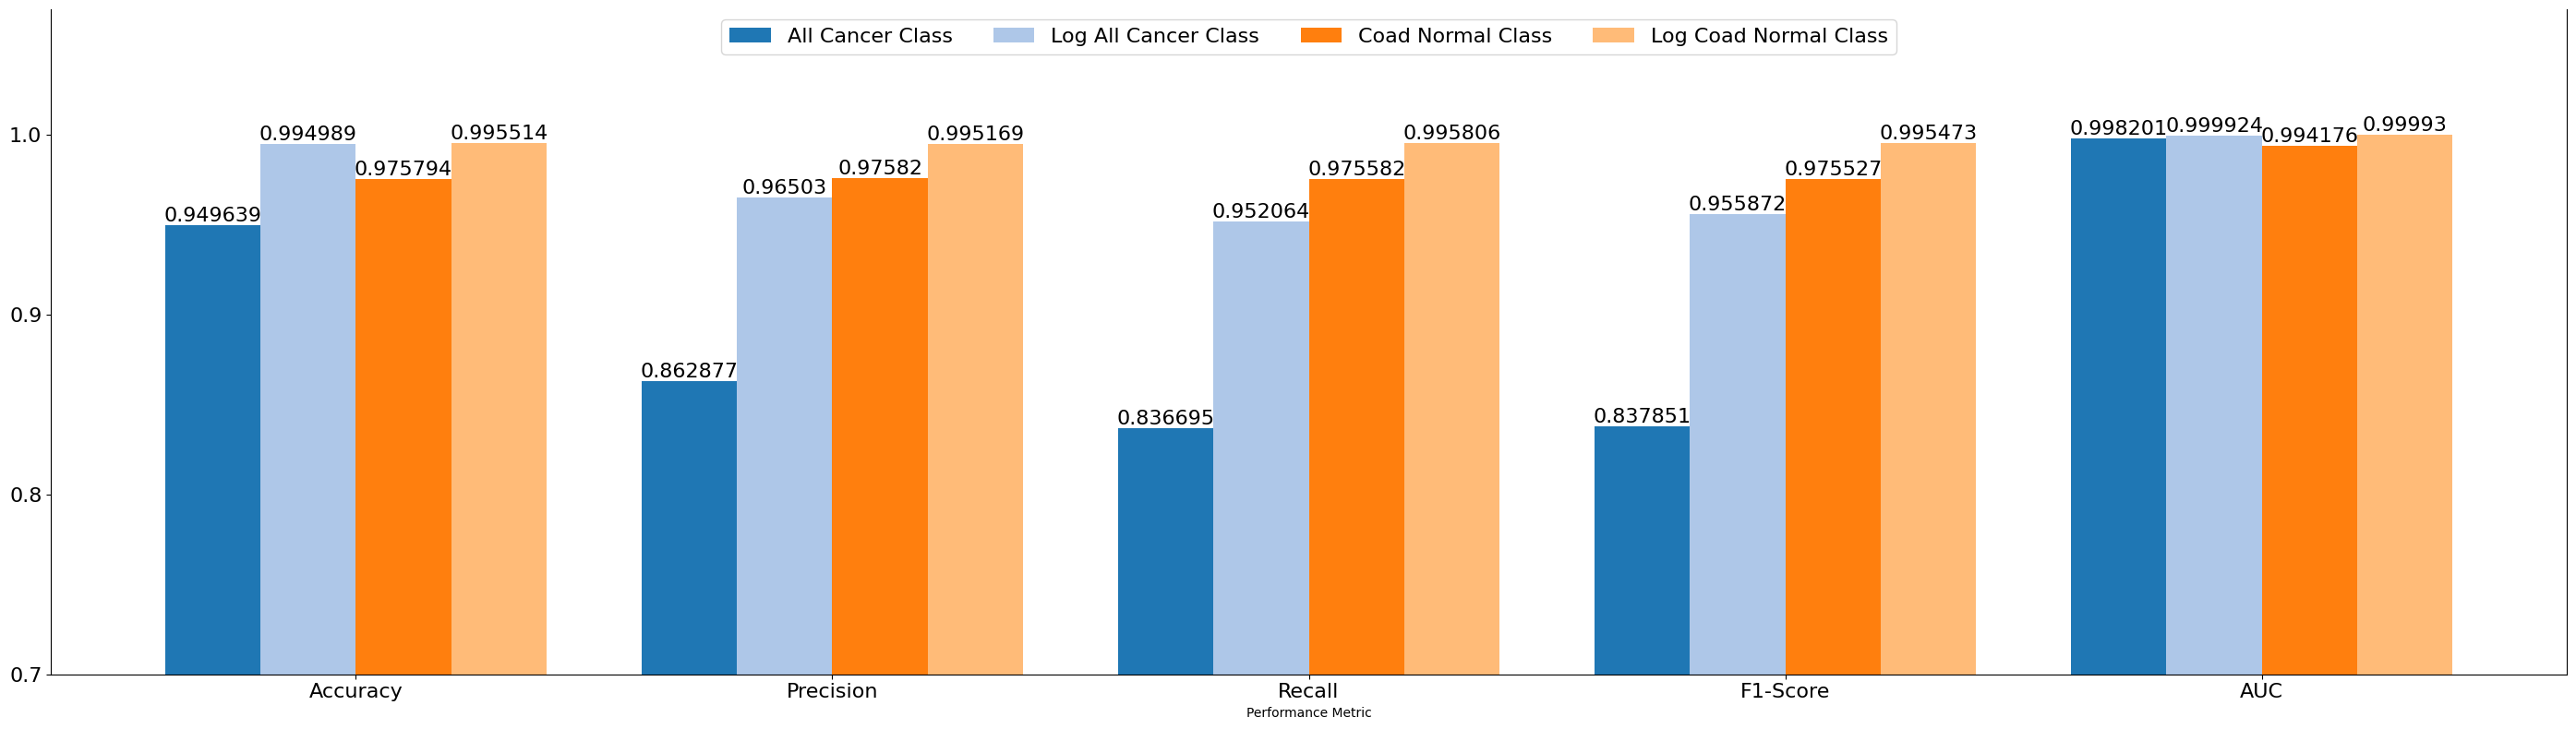

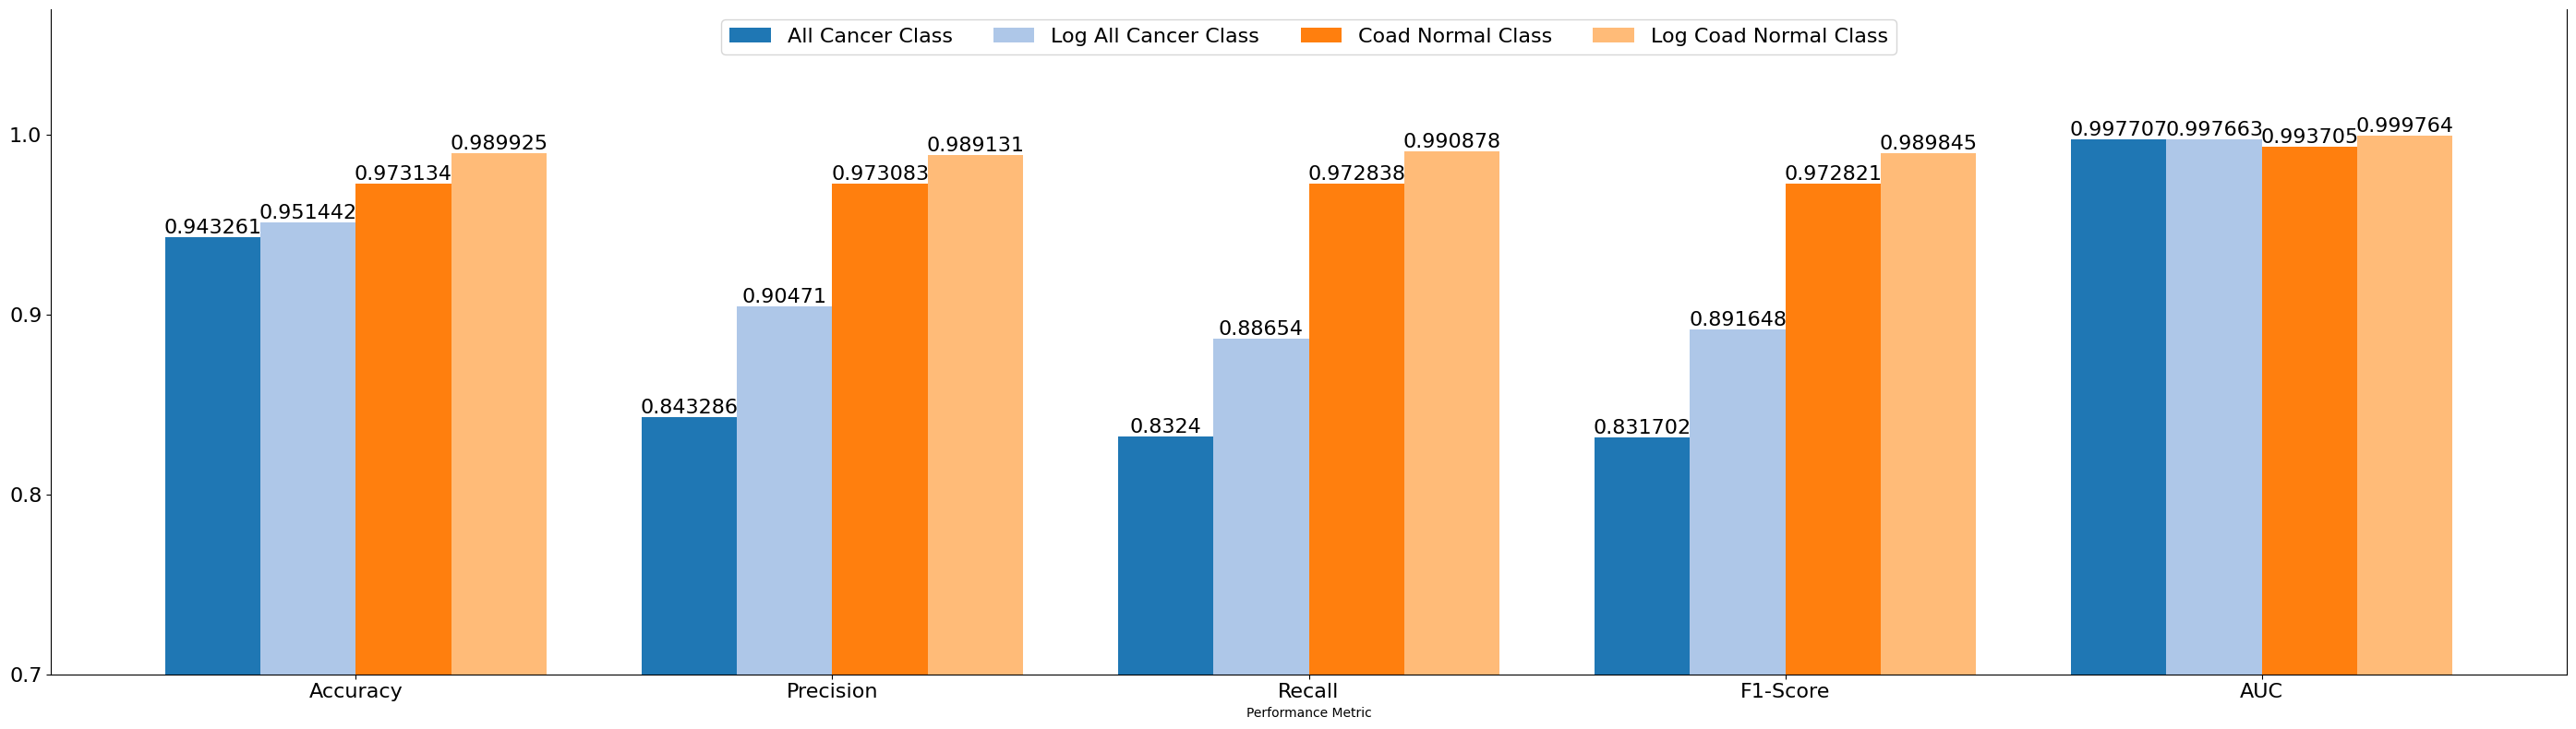

In [201]:
plot_performance_metrics(EXPERIMENTS)

# Interprete the Shap Values of the model

In [5]:
# get all shap_values
def get_highest_shap_values(file_pattern: str, num_ftrs: int):
    print(f'Load values matching the pattern {file_pattern}')
    highest_shap_values = {omic: [] for omic in OMICS}
    omic_features = {omic: [] for omic in OMICS}
    for omic in OMICS:
        for f in Path(omic).glob(f'shap_values_{file_pattern}.tsv'):
            df = pd.read_csv(f, sep='\t', index_col=0)
            # get the values of the data frame as a numpy array
            values = df.values
            # get the highest mean of the shap values. The absolute values can be chosen to add the overall impact, but might ignore
            # negative influence on the epigenetic expression; a crucial part for negative correlation
            most_influential_idx = np.argsort(np.abs(values.mean(0)))
            # write the indices of the most influential features into an array
            highest_shap_values[omic].append(most_influential_idx[-num_ftrs:])
            # save the top features as ids
            omic_features[omic].append([*df.columns[most_influential_idx[-num_ftrs:]]])
    return omic_features

In [6]:
all_cancer_omic_features = get_highest_shap_values(ALL_CANCERS_FILE_PATTERN, 50)
coad_normal_omic_features = get_highest_shap_values(COAD_NORMAL_FILE_PATTERN, 50)
log_all_cancer_omic_features = get_highest_shap_values(LOG_ALL_CANCERS_FILE_PATTERN, 50)
log_coad_normal_omic_features = get_highest_shap_values(LOG_COAD_NORMAL_FILE_PATTERN, 50)

Load values matching the pattern all_cancer_classification_v05_[0-9]*
Load values matching the pattern coad_normal_classification_v05_[0-9]*
Load values matching the pattern all_cancer_classification_log_v05_[0-9]*
Load values matching the pattern coad_normal_classification_log_v05_[0-9]*


In [7]:
def set_subplot(omic_features: dict, ax: plt.Axes, omic: str, max_ftrs: int = 10, feature_file_suffix: str = None):
    # set the values
    features = [] 
    for ftrs in omic_features[omic]:
        features += ftrs
    feature_counts = pd.Series(features).value_counts()
    feature_counts = feature_counts.iloc[:max_ftrs]
    x_coordinates = feature_counts.values
    y_coordinates = range(max_ftrs, 0, -1)

    # define the colors for each label
    cmap = colormaps['Set2']
    cat_to_write = ['VAE'] * max_ftrs
    colors = [cmap(6)] * max_ftrs
    # color the features that were only identified by MOFA
    for ftr in MOFA_CANDIDATE_FTRS[omic]:
        if ftr not in feature_counts.index:
            continue
        idx = feature_counts.index.get_loc(ftr)
        cat_to_write[idx] = 'MOFA'
        colors[idx] = cmap(1)
    # color the features that were only identified by MOFA
    for ftr in LITERATURE_FTRS[omic]:
        if ftr not in feature_counts.index:
            continue
        idx = feature_counts.index.get_loc(ftr)
        cat_to_write[idx] = 'LIT'
        colors[idx] = cmap(4)
    # color the features that were identified by MOFA and found in literature
    # features overlapping with the previous two setting are overwritten
    for ftr in JOINT_FTRS[omic]:
        if ftr not in feature_counts.index:
            continue
        idx = feature_counts.index.get_loc(ftr)
        cat_to_write[idx] = 'ALL'
        colors[idx] = cmap(2)

    # write the feature counts into a csv file
    pd.DataFrame({'Occurence': feature_counts.values, 'Category': cat_to_write}, index=feature_counts.index).to_csv(f'Shap_values/features_{omic}{feature_file_suffix}.tsv', sep='\t', index=True)

    
    # set plot attributes
    ax.barh(y_coordinates, x_coordinates, align='center', color=colors)
    ax.set_xlabel('Number of runs where the feature was ranked in the top 20 of most influential features')
    ax.set_ylabel('Feature ID')
    ax.set_yticks(y_coordinates, feature_counts.index)
    ax.set_xticks(range(21))
    ax.set_xbound(0, 21)
    ax.tick_params(axis='y', labelsize=14)
    ax.invert_yaxis
    ax.set_title(f'Top Features for {omic.replace('_', ' ')}')
    ax.legend(handles=[Patch(color=cmap(6), label='Candidate only by VAE'),
                       Patch(color=cmap(1), label='Candidate also found by MOFA'),
                       Patch(color=cmap(4), label='Candidate described in literature'),
                       Patch(color=cmap(2), label='Candidate found by VAE,\n MOFA and in literature')],
             loc='lower right')

    return ax

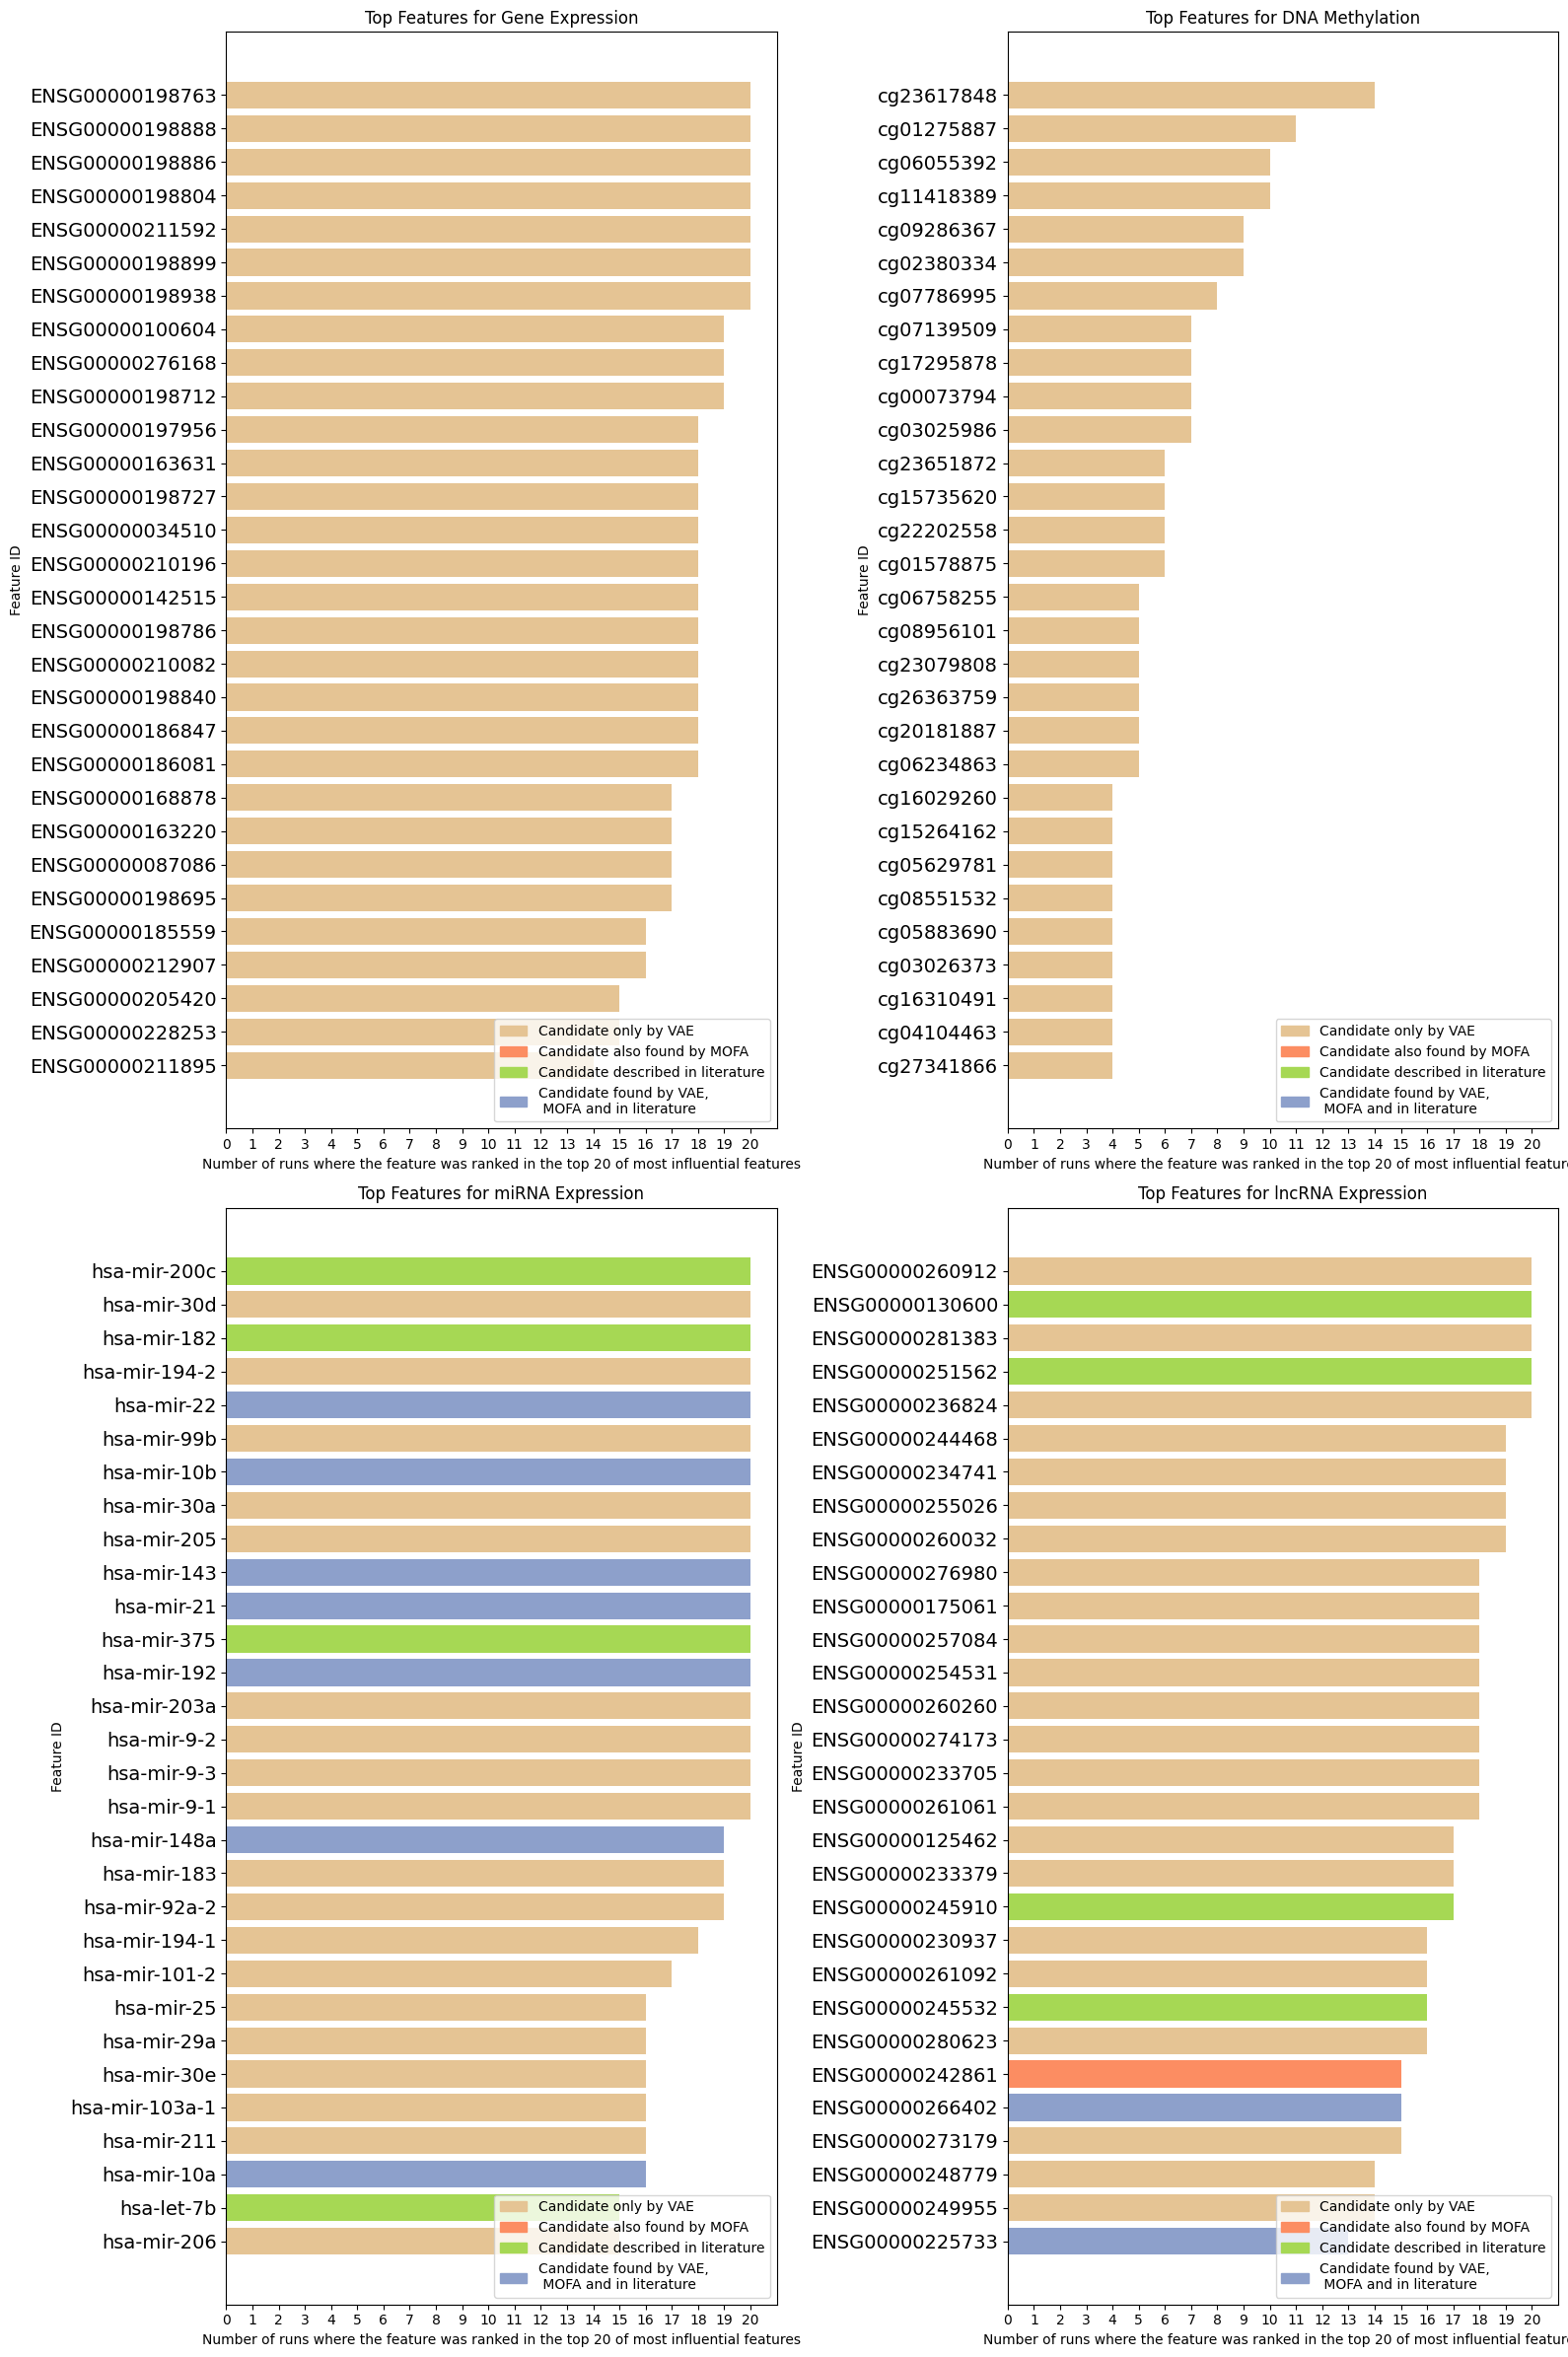

In [8]:
# plot the most observed features for the all cancer experiment
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(24)
fig.set_figwidth(16)
ax1 = set_subplot(all_cancer_omic_features, ax1, OMICS[0], 30)
ax2 = set_subplot(all_cancer_omic_features, ax2, OMICS[1], 30)
ax3 = set_subplot(all_cancer_omic_features, ax3, OMICS[2], 30)
ax4 = set_subplot(all_cancer_omic_features, ax4, OMICS[3], 30)

plt.tight_layout()
plt.savefig('Shap_values/all_cancer_shap_values_plot.png')
plt.show()


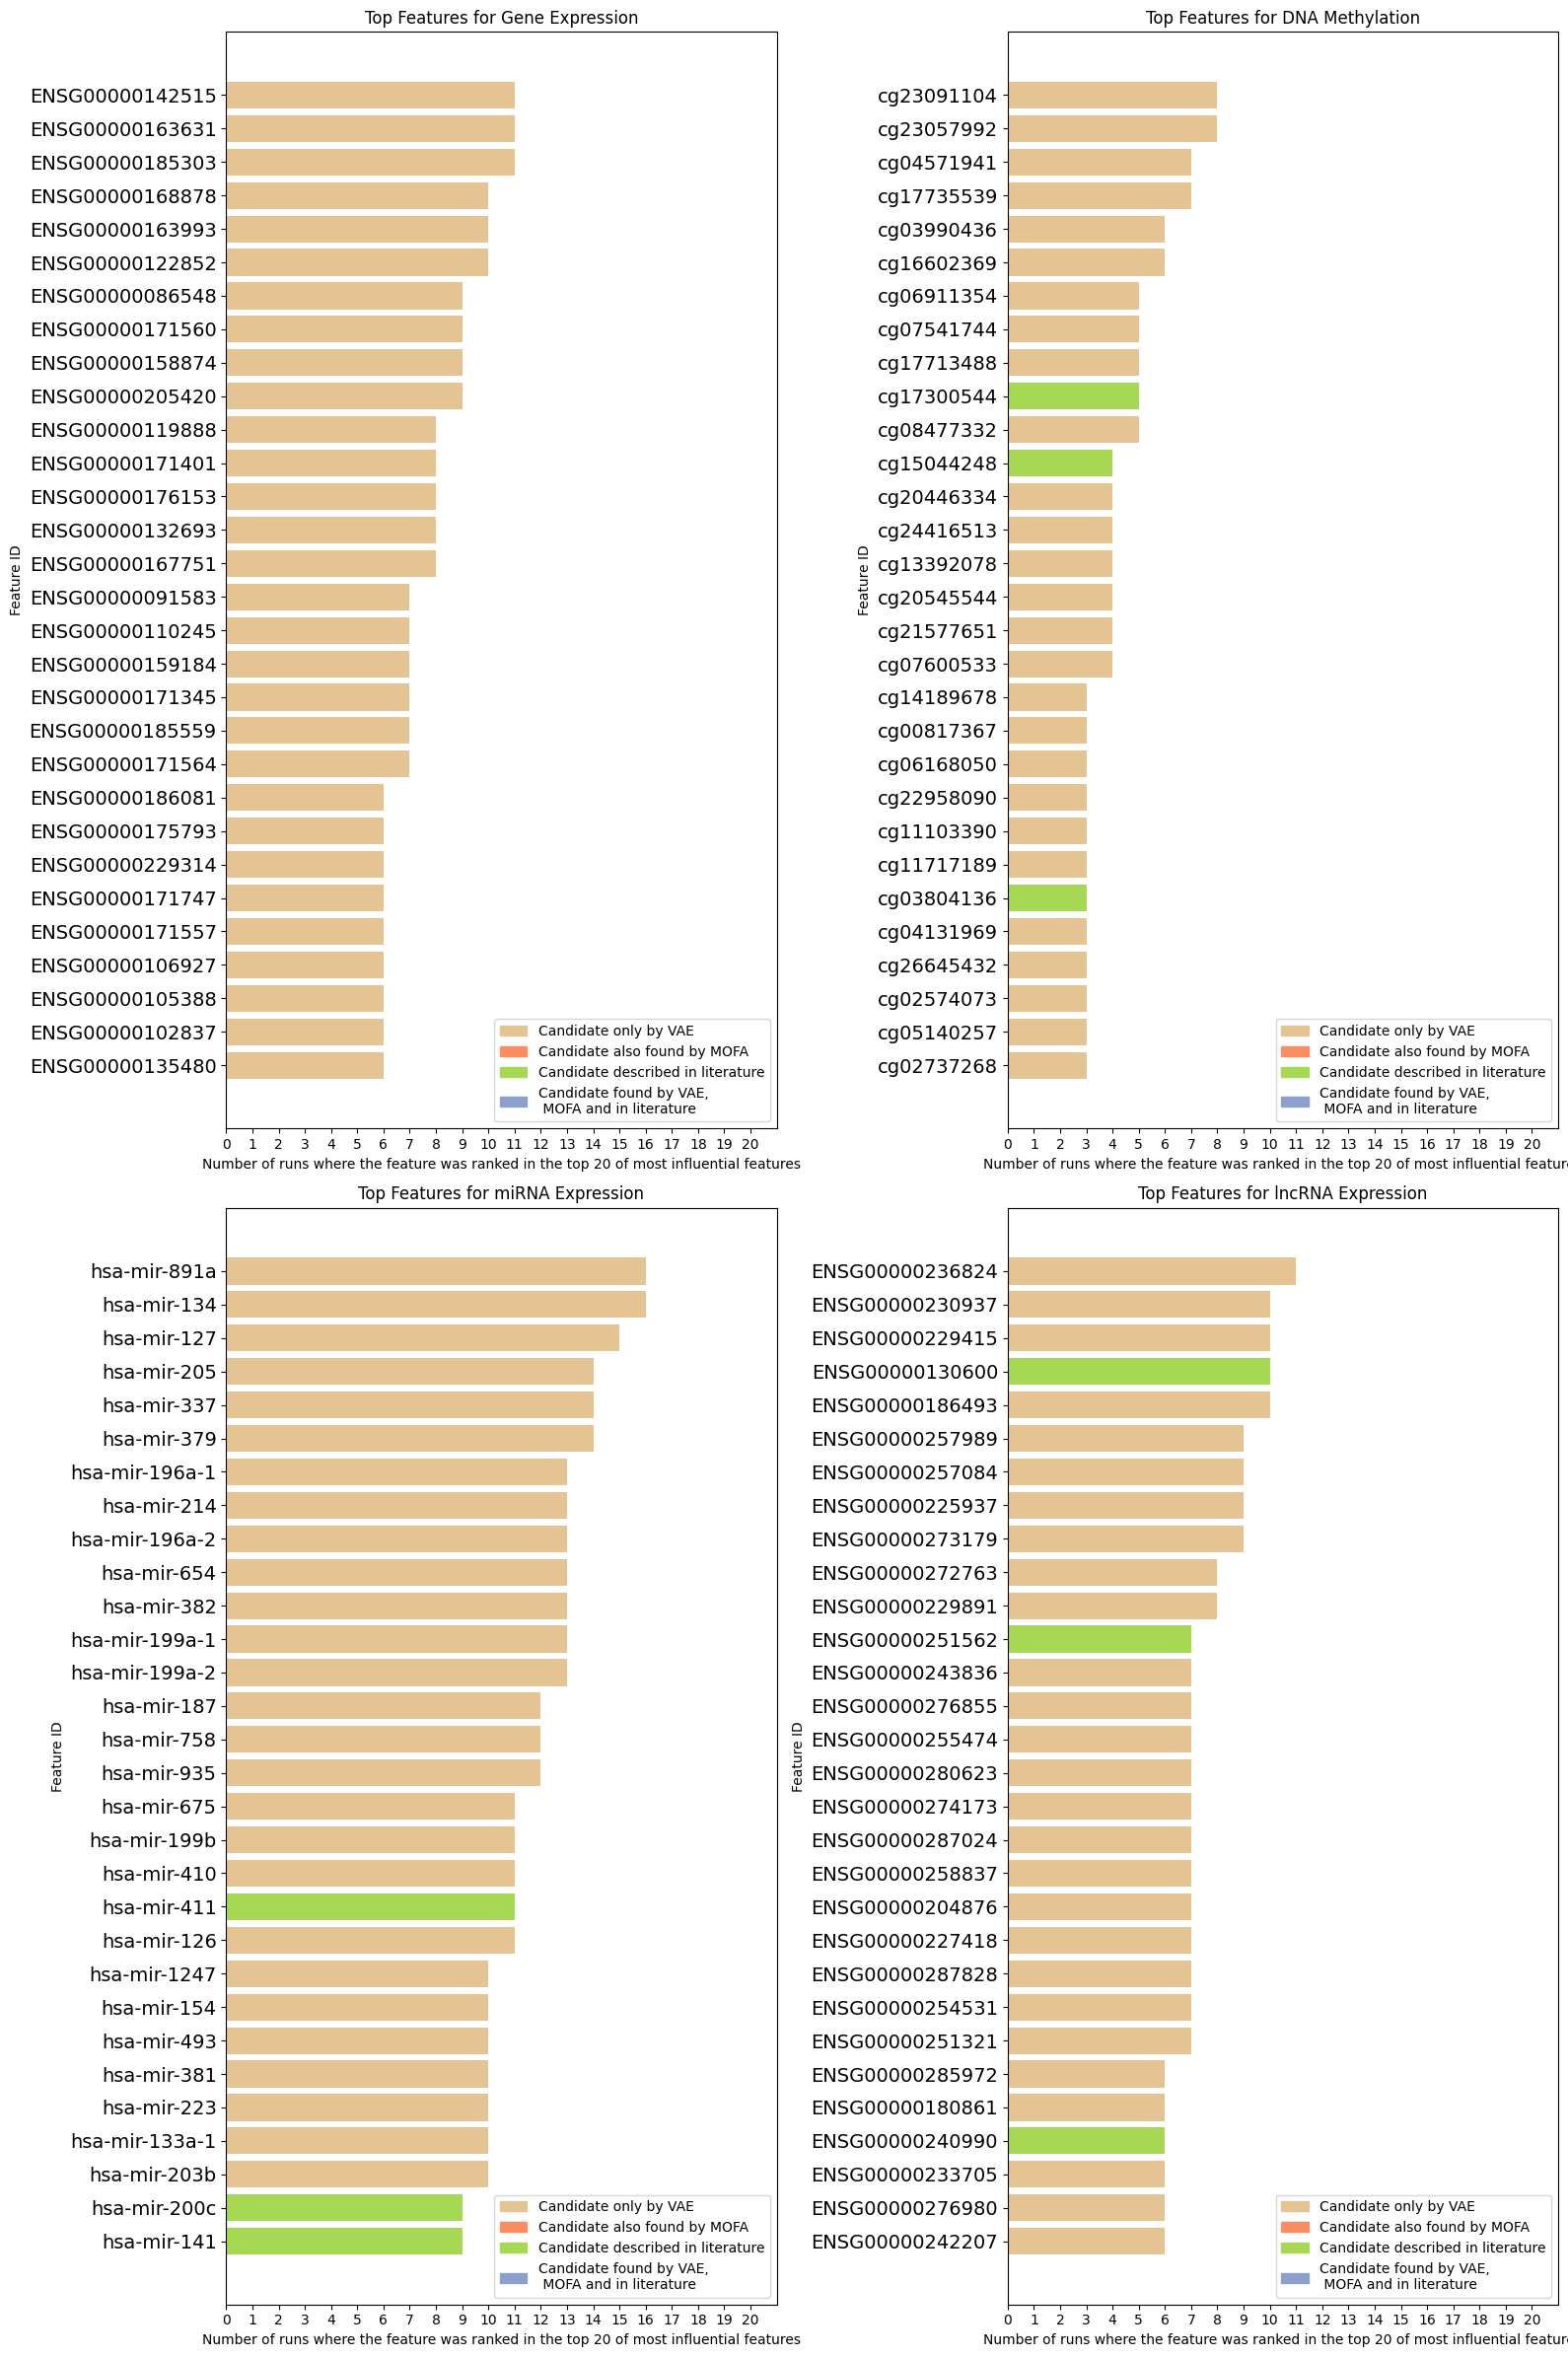

In [9]:
# plot the most observed features for the all cancer experiment with log counts
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(24)
fig.set_figwidth(16)
ax1 = set_subplot(log_all_cancer_omic_features, ax1, OMICS[0], 30)
ax2 = set_subplot(log_all_cancer_omic_features, ax2, OMICS[1], 30)
ax3 = set_subplot(log_all_cancer_omic_features, ax3, OMICS[2], 30)
ax4 = set_subplot(log_all_cancer_omic_features, ax4, OMICS[3], 30)

plt.tight_layout()
plt.savefig('Shap_values/log_all_cancer_shap_values_plot.png')
plt.show()


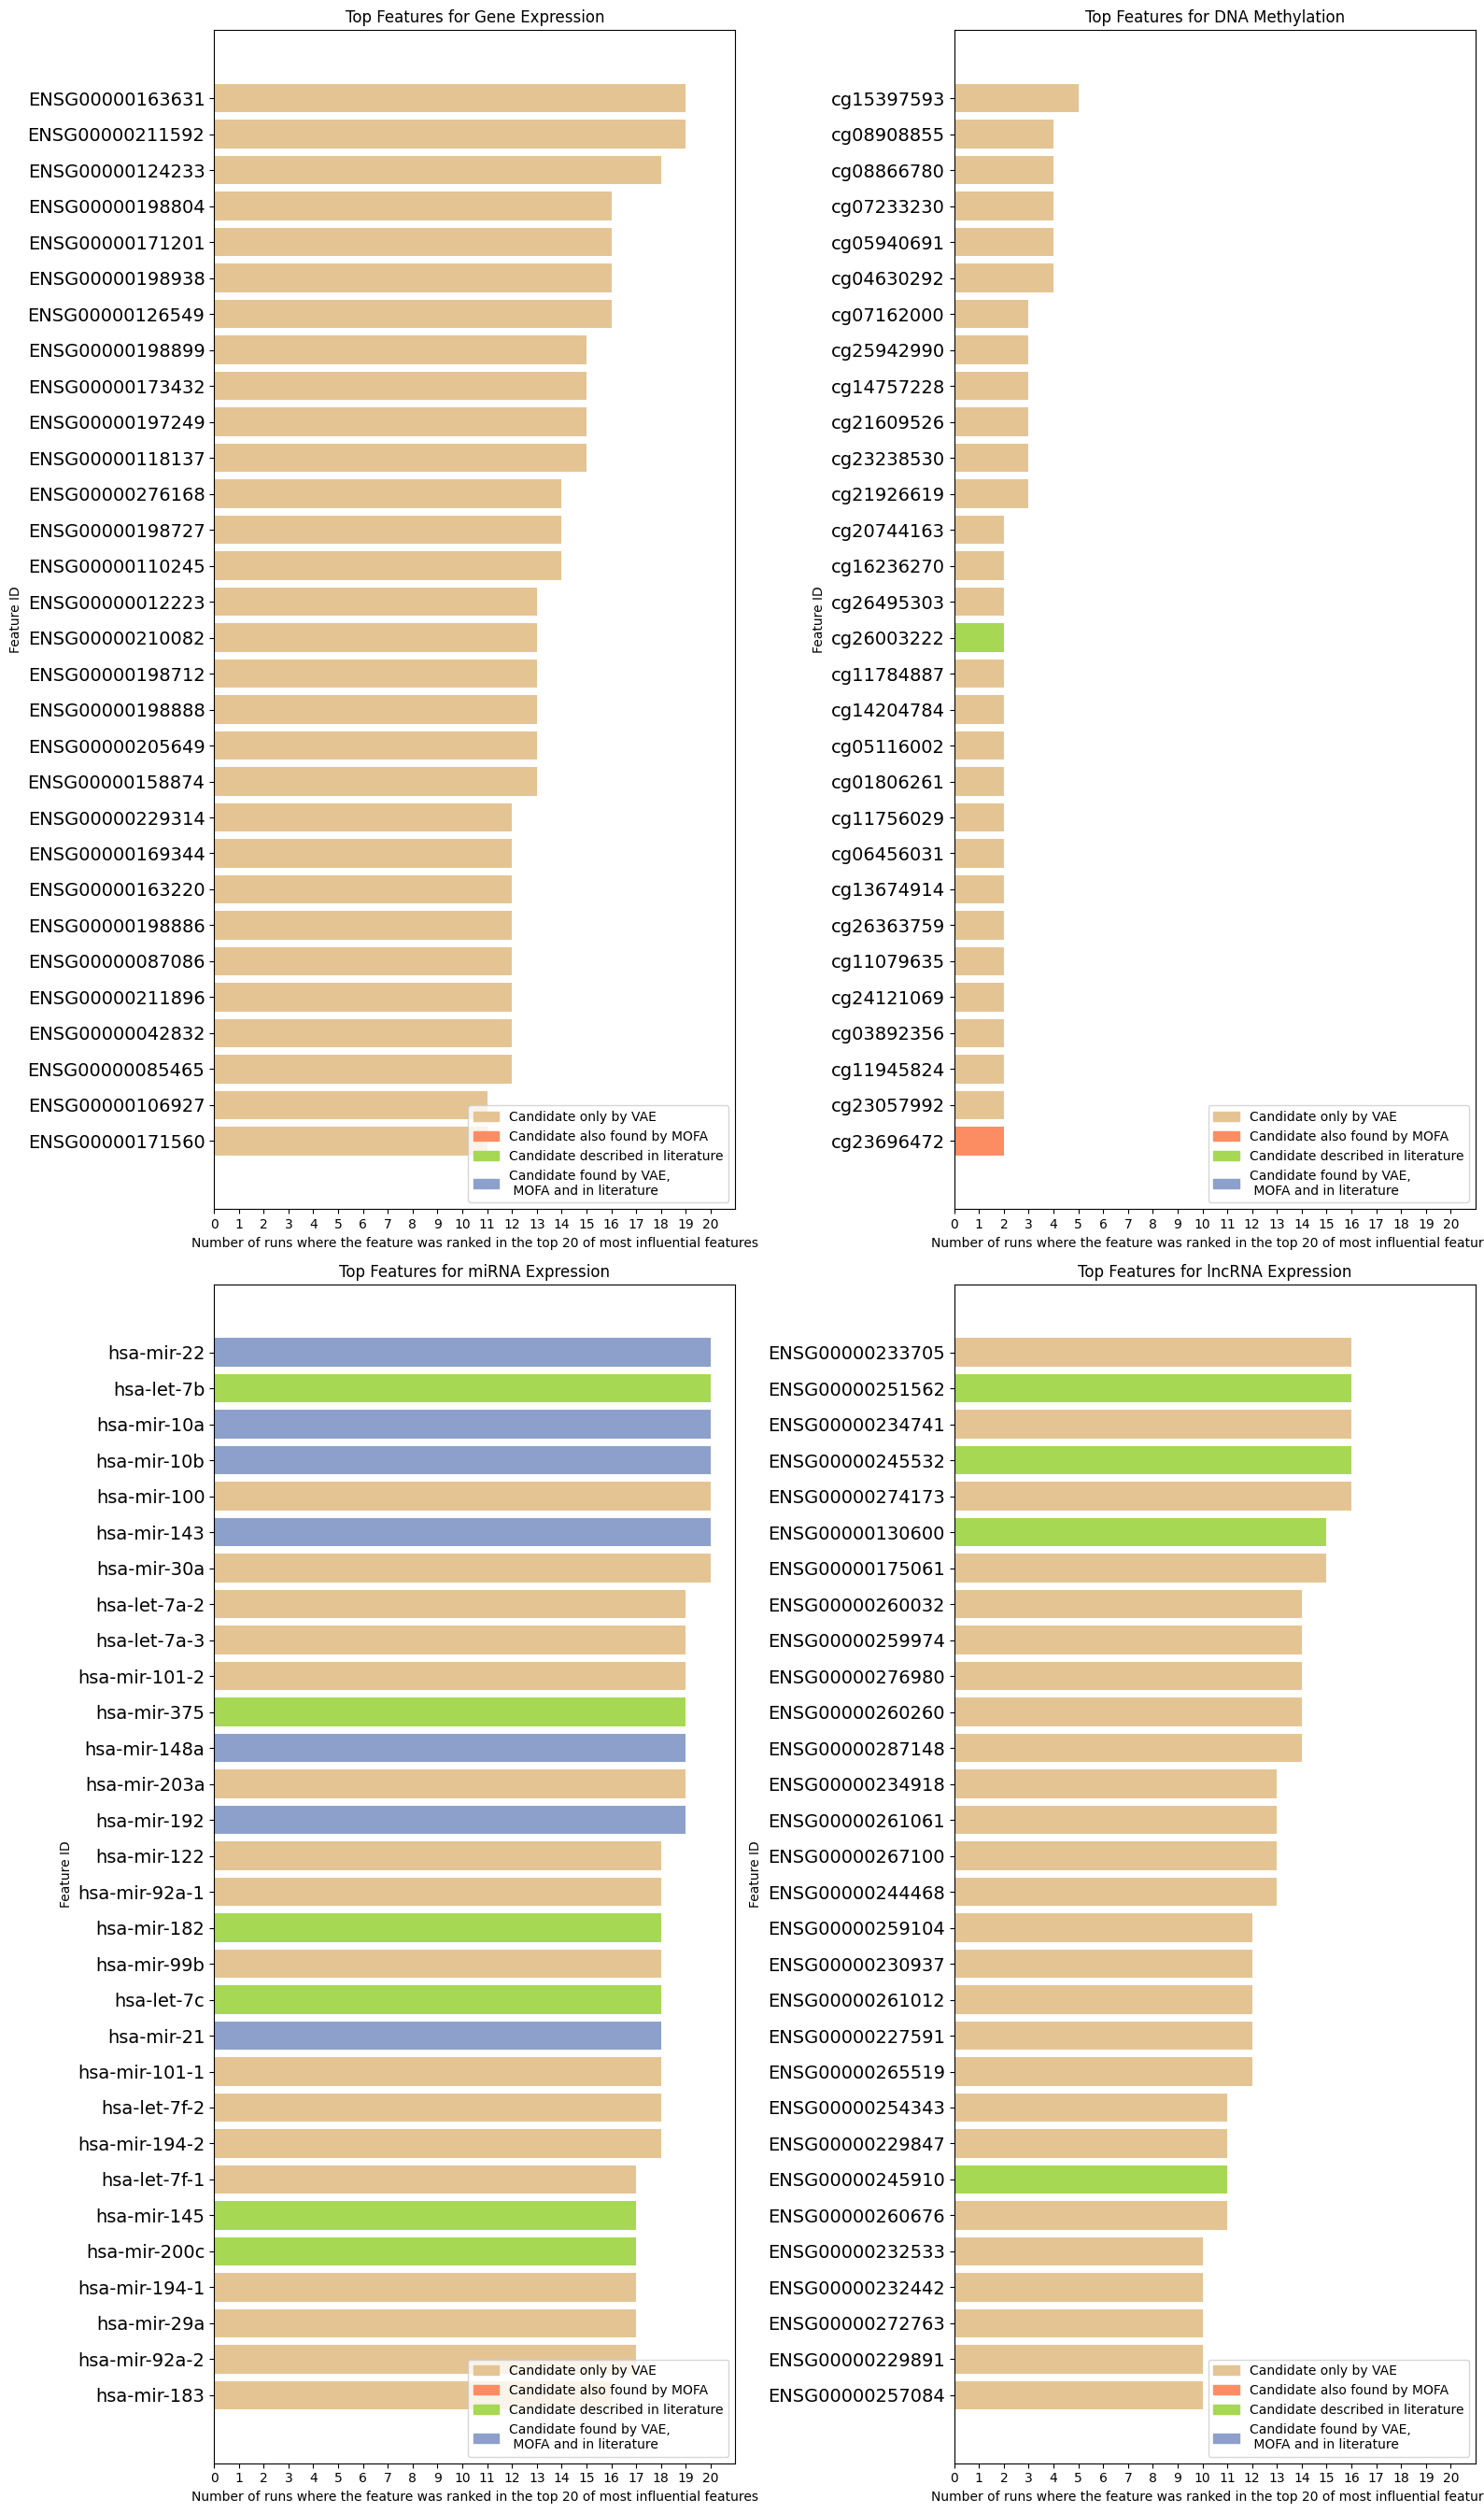

In [10]:
# plot the most observed features for the coad normal experiment
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(27)
fig.set_figwidth(16)
ax1 = set_subplot(coad_normal_omic_features, ax1, OMICS[0], 30)
ax2 = set_subplot(coad_normal_omic_features, ax2, OMICS[1], 30)
ax3 = set_subplot(coad_normal_omic_features, ax3, OMICS[2], 30)
ax4 = set_subplot(coad_normal_omic_features, ax4, OMICS[3], 30)

plt.tight_layout()
plt.savefig('Shap_values/coad_normal_shap_values_plot.png')
plt.show()

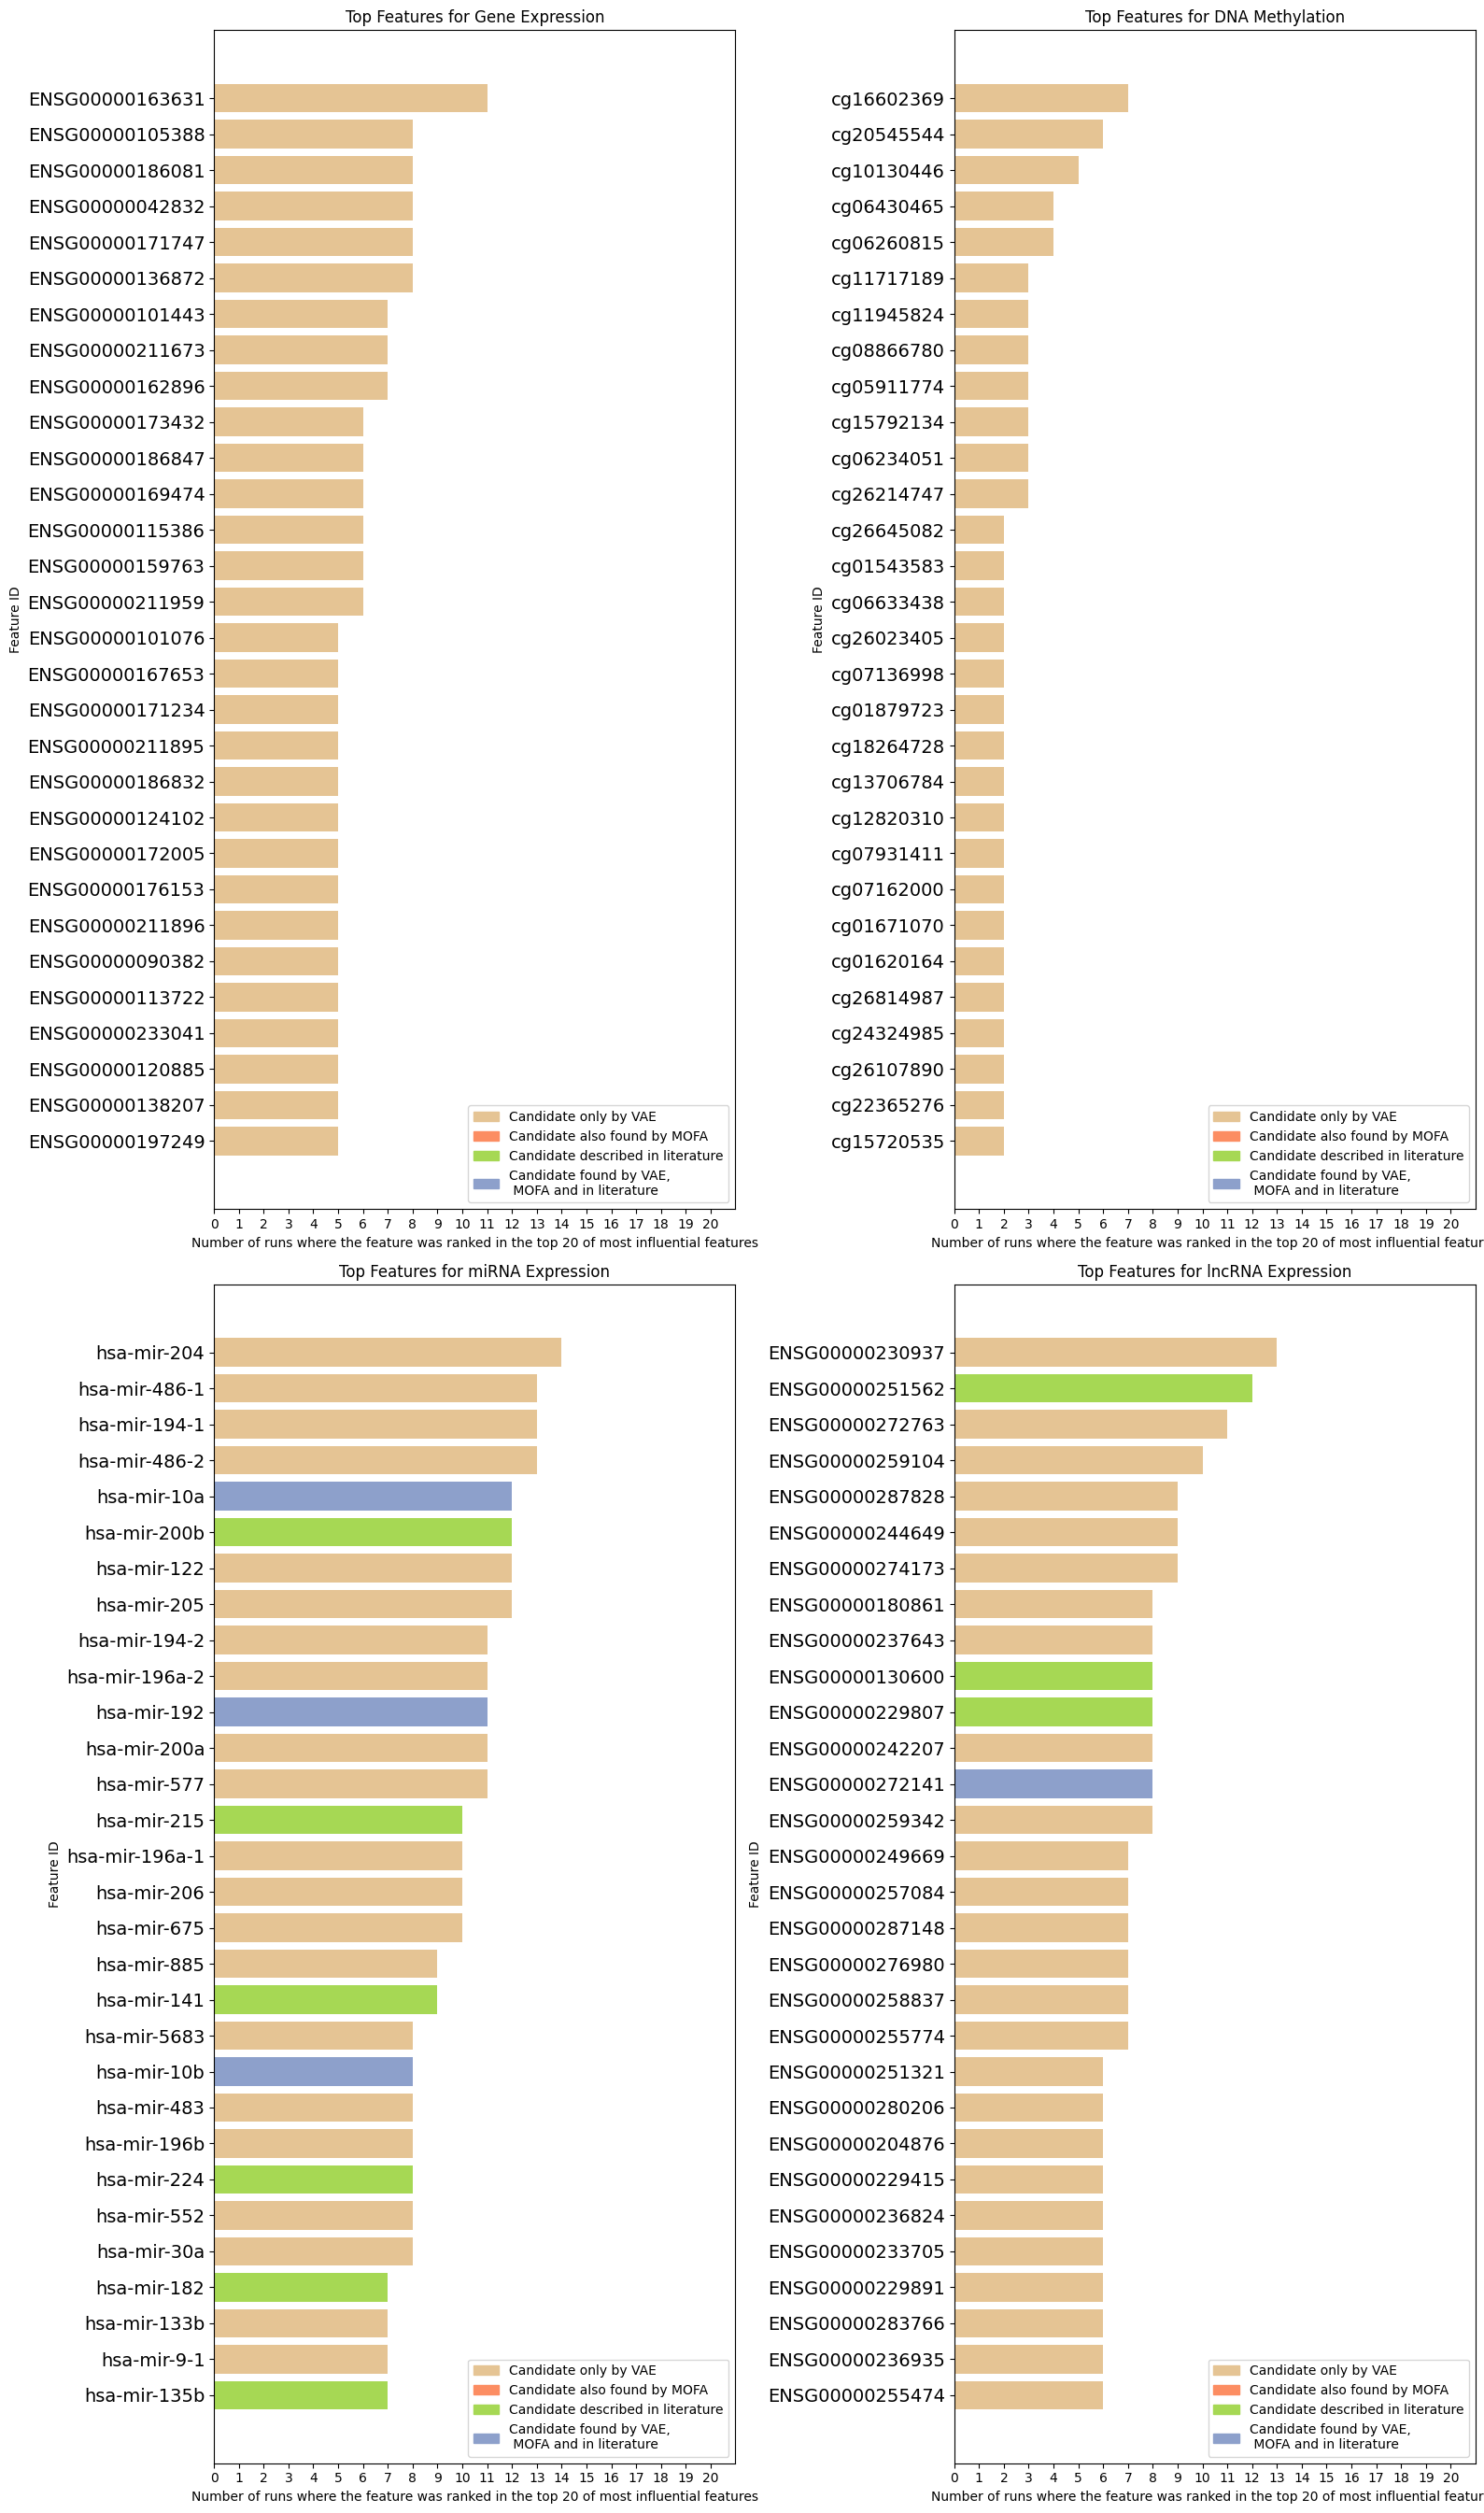

In [11]:
# plot the most observed features for the coad normal experiment with log counts
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(27)
fig.set_figwidth(16)
ax1 = set_subplot(log_coad_normal_omic_features, ax1, OMICS[0], 30)
ax2 = set_subplot(log_coad_normal_omic_features, ax2, OMICS[1], 30)
ax3 = set_subplot(log_coad_normal_omic_features, ax3, OMICS[2], 30)
ax4 = set_subplot(log_coad_normal_omic_features, ax4, OMICS[3], 30)

plt.tight_layout()
plt.savefig('Shap_values/log_coad_normal_shap_values_plot.png')
plt.show()

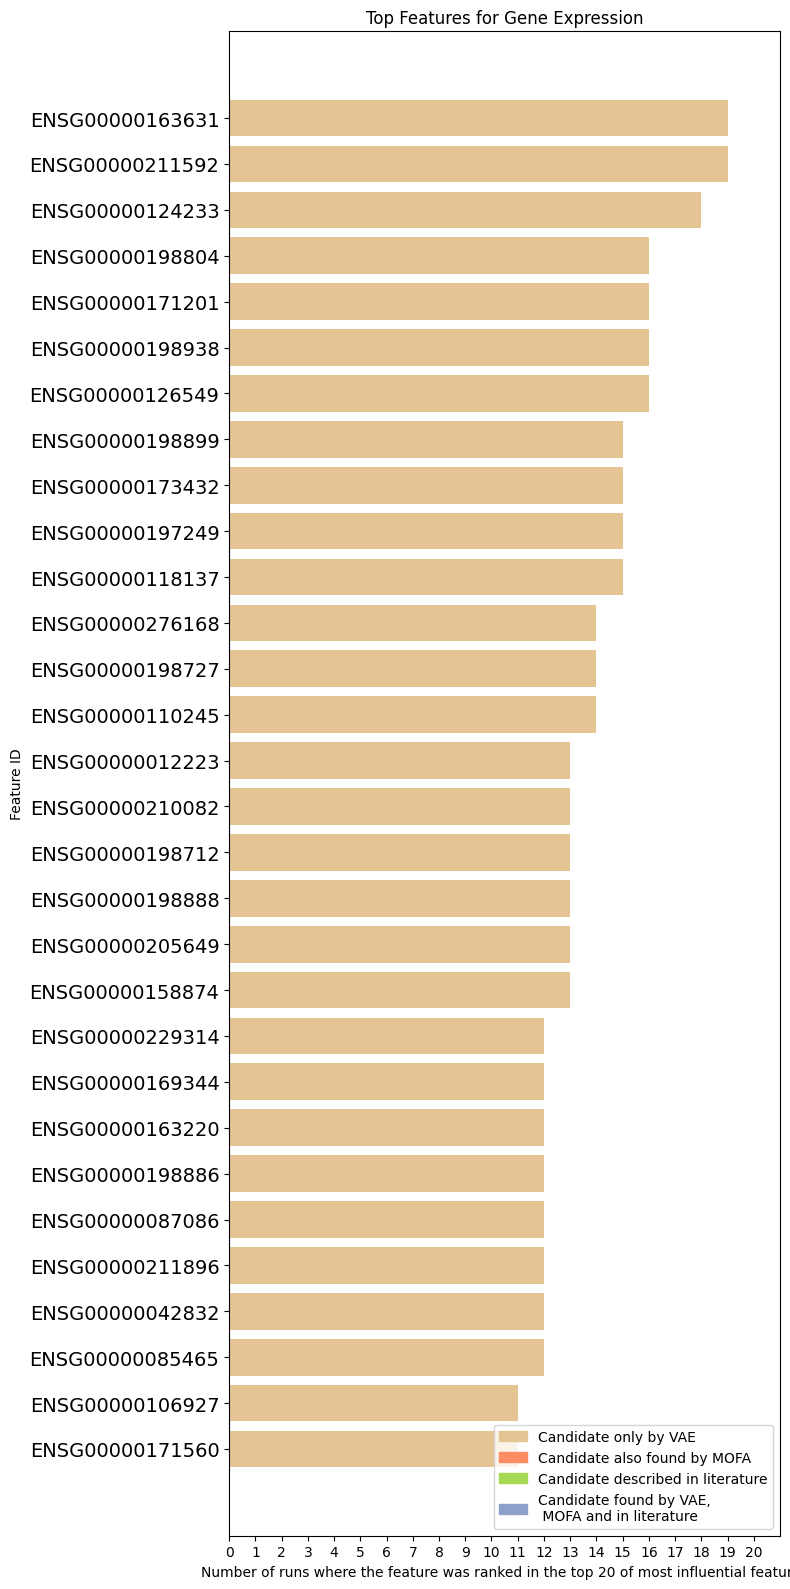

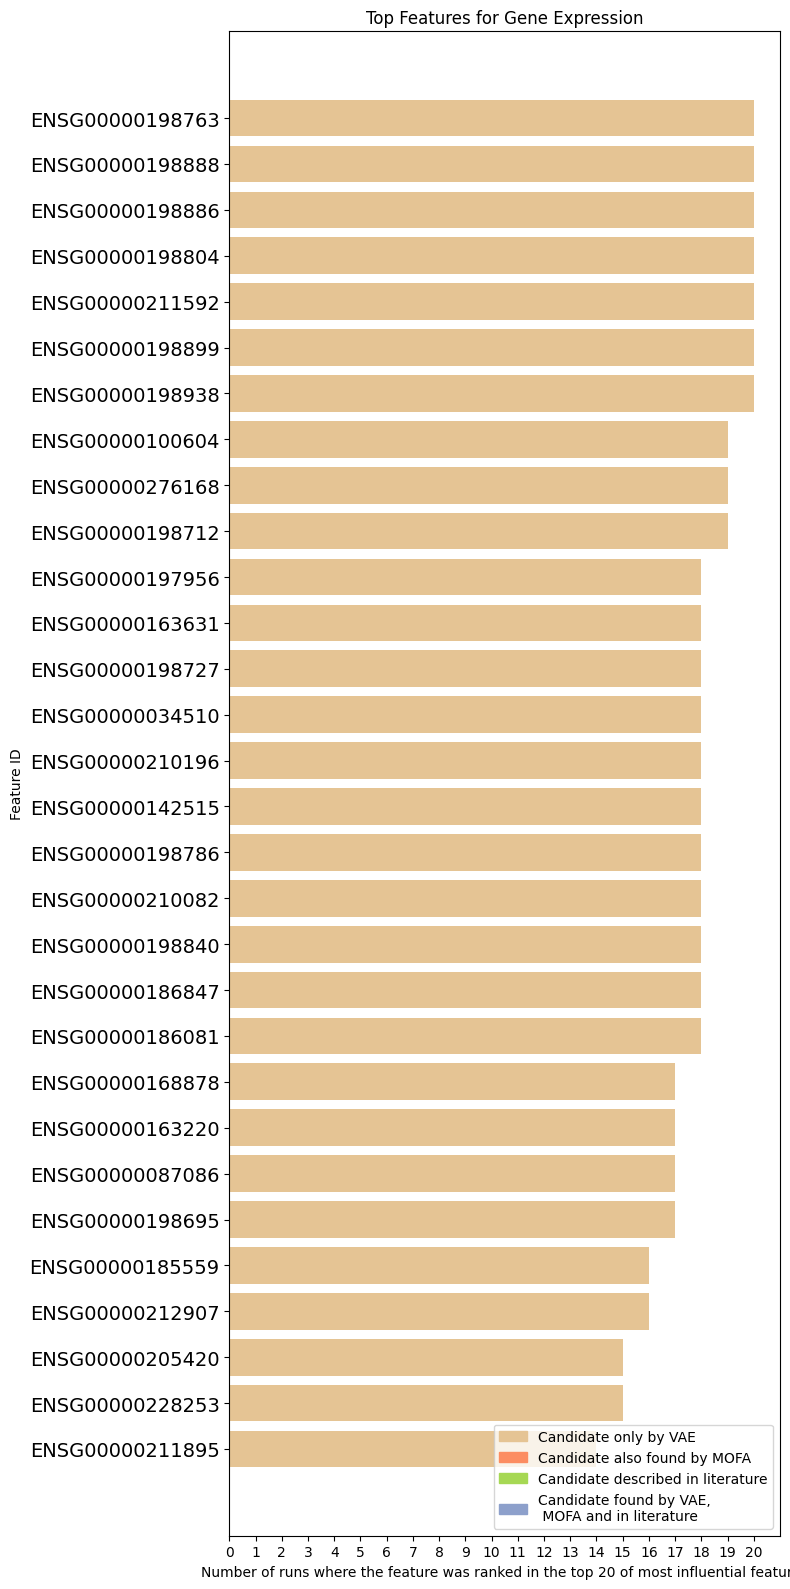

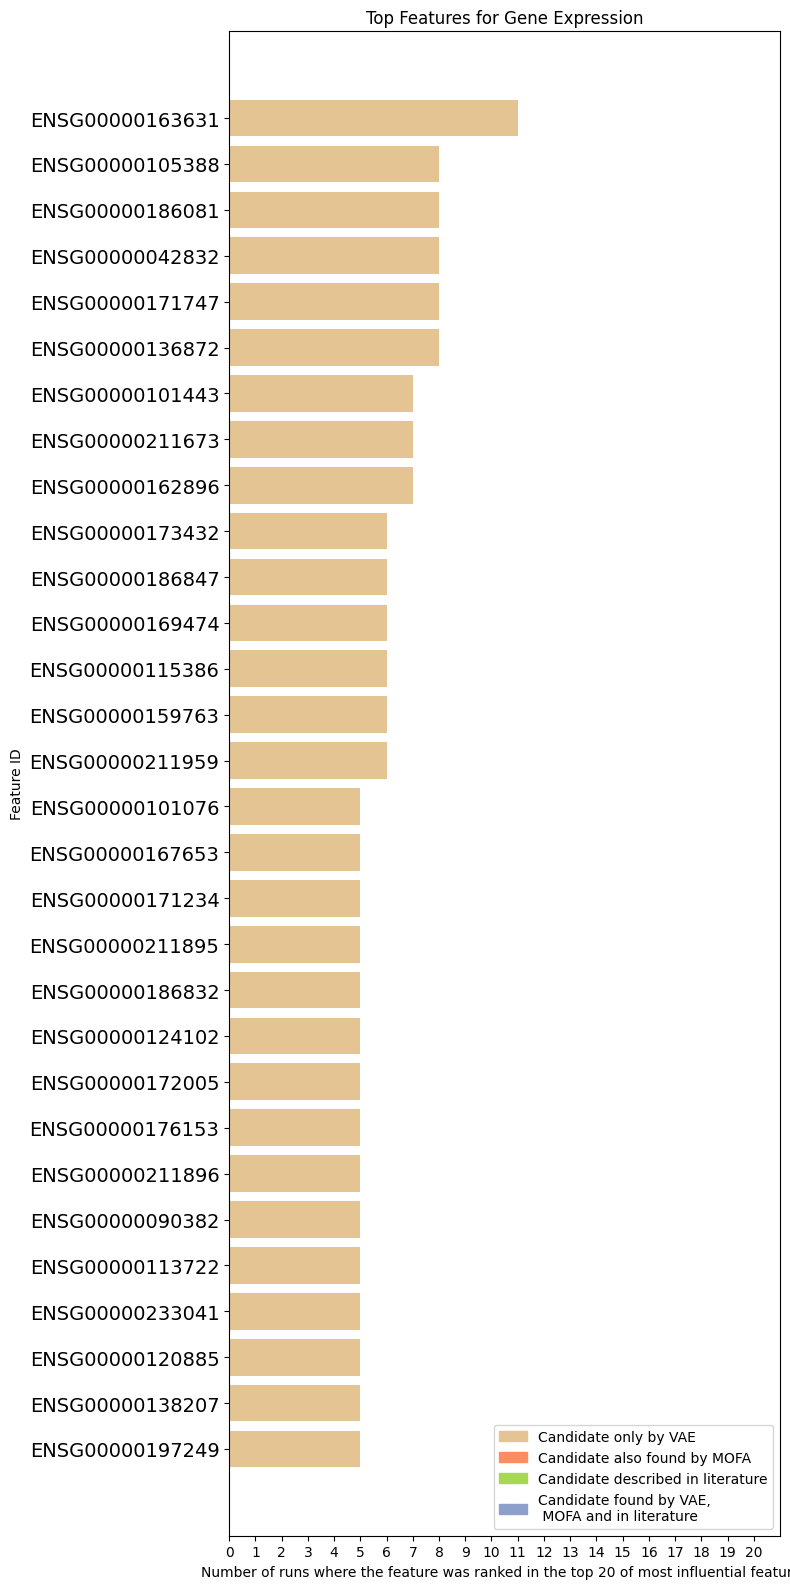

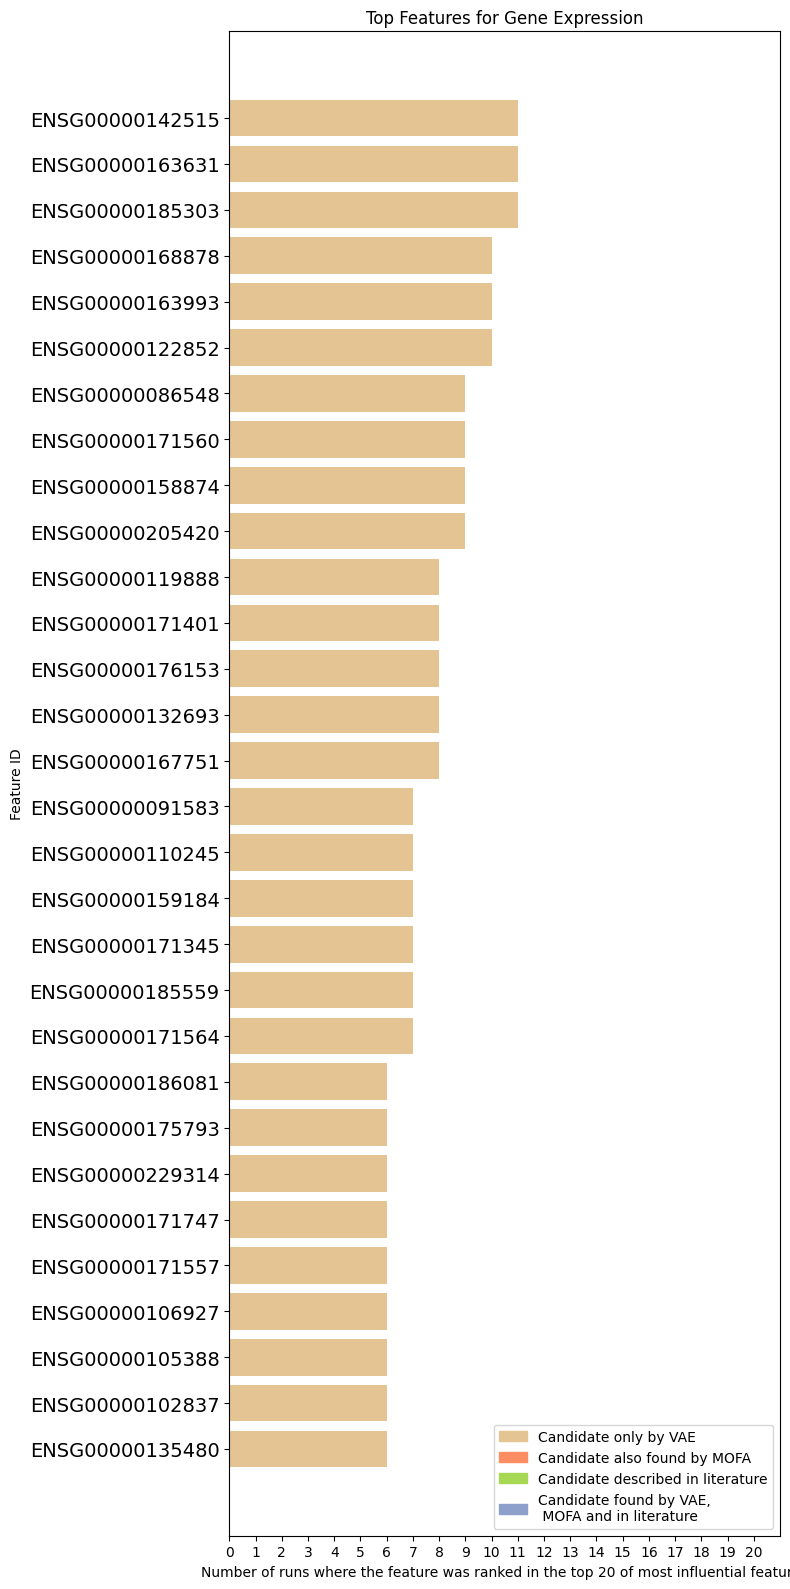

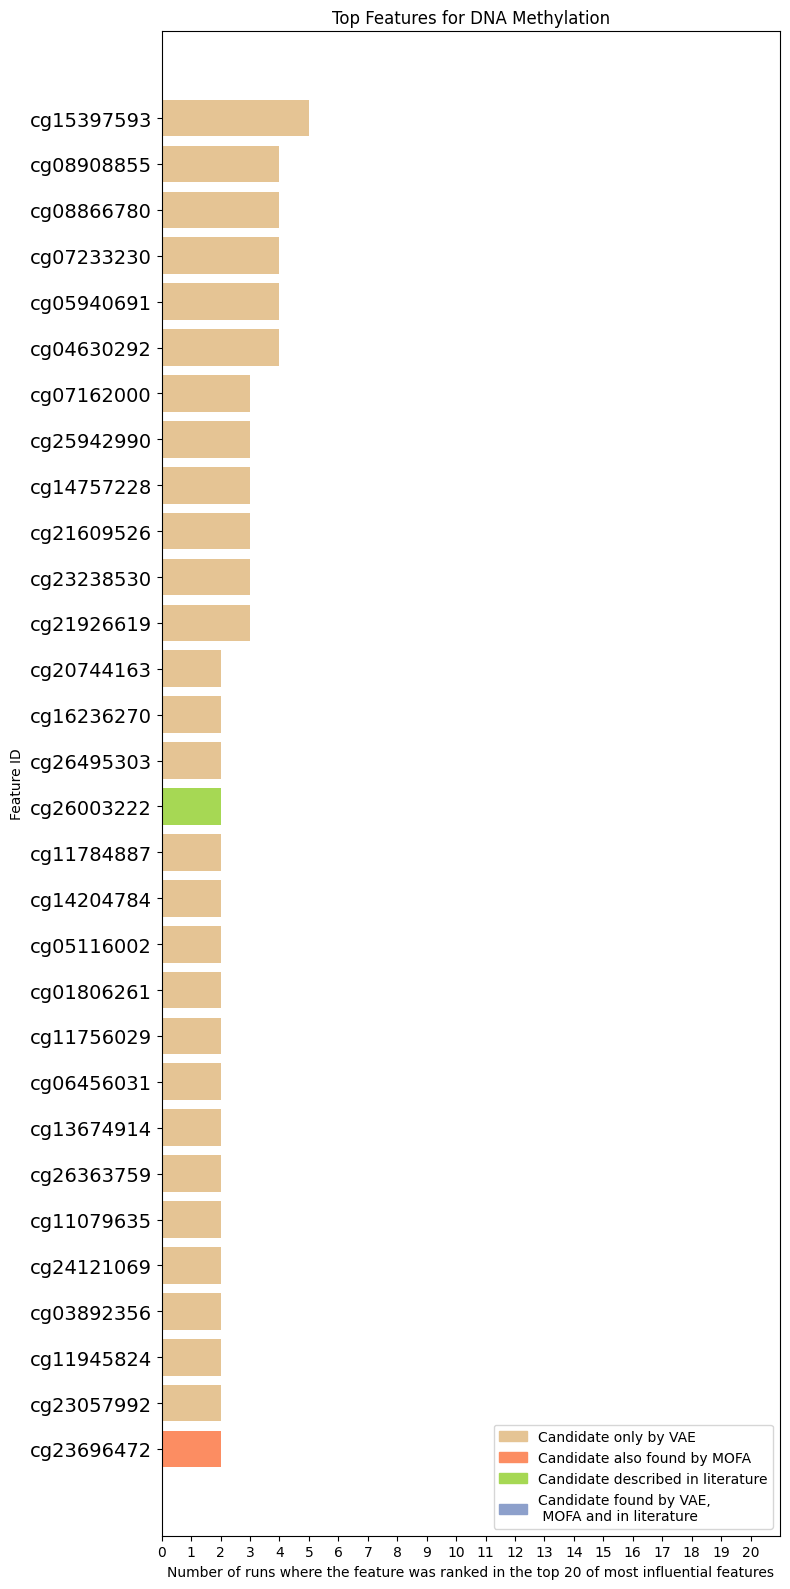

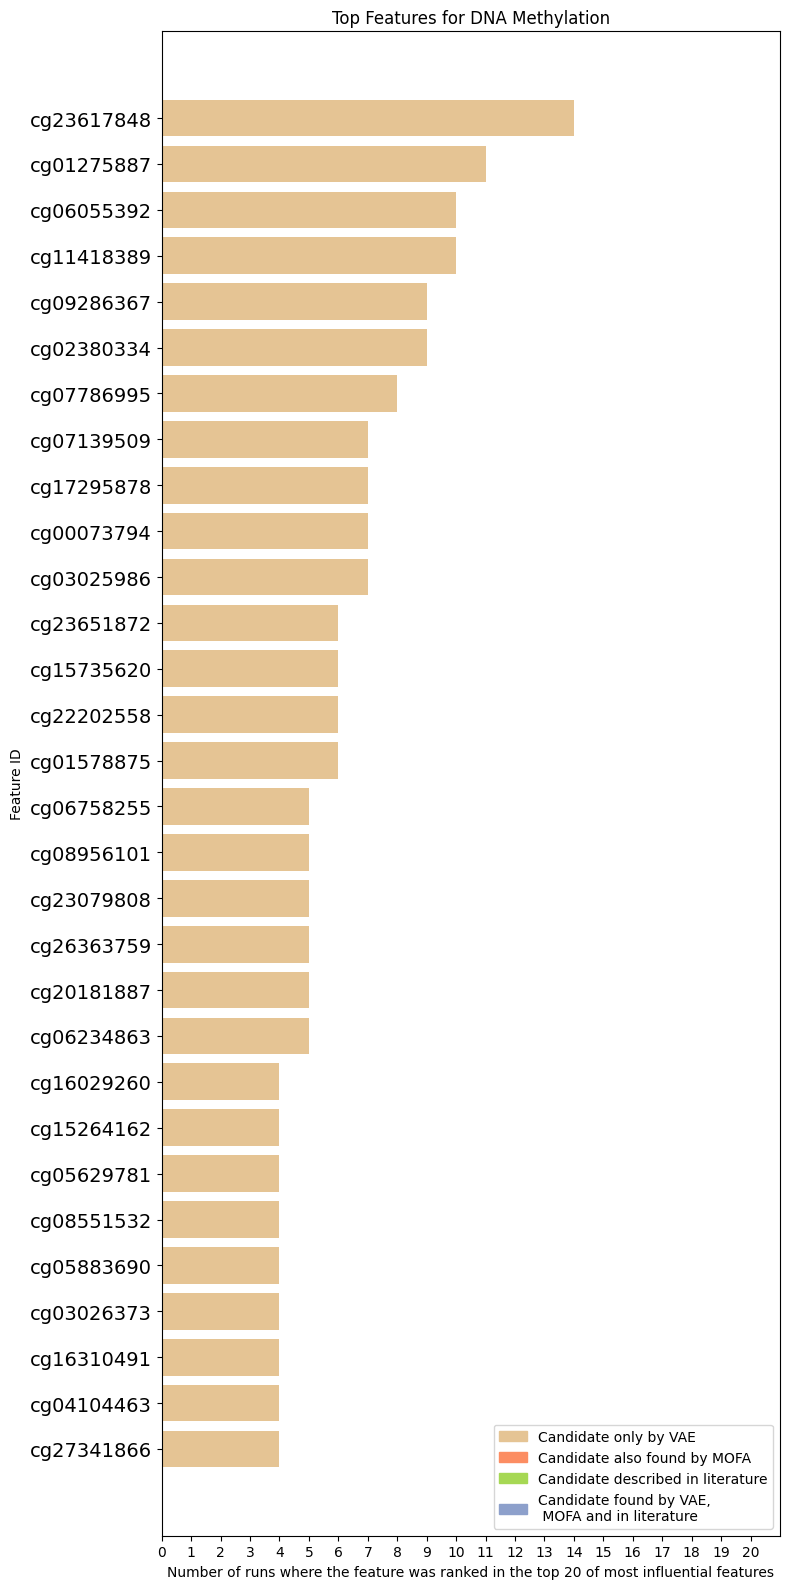

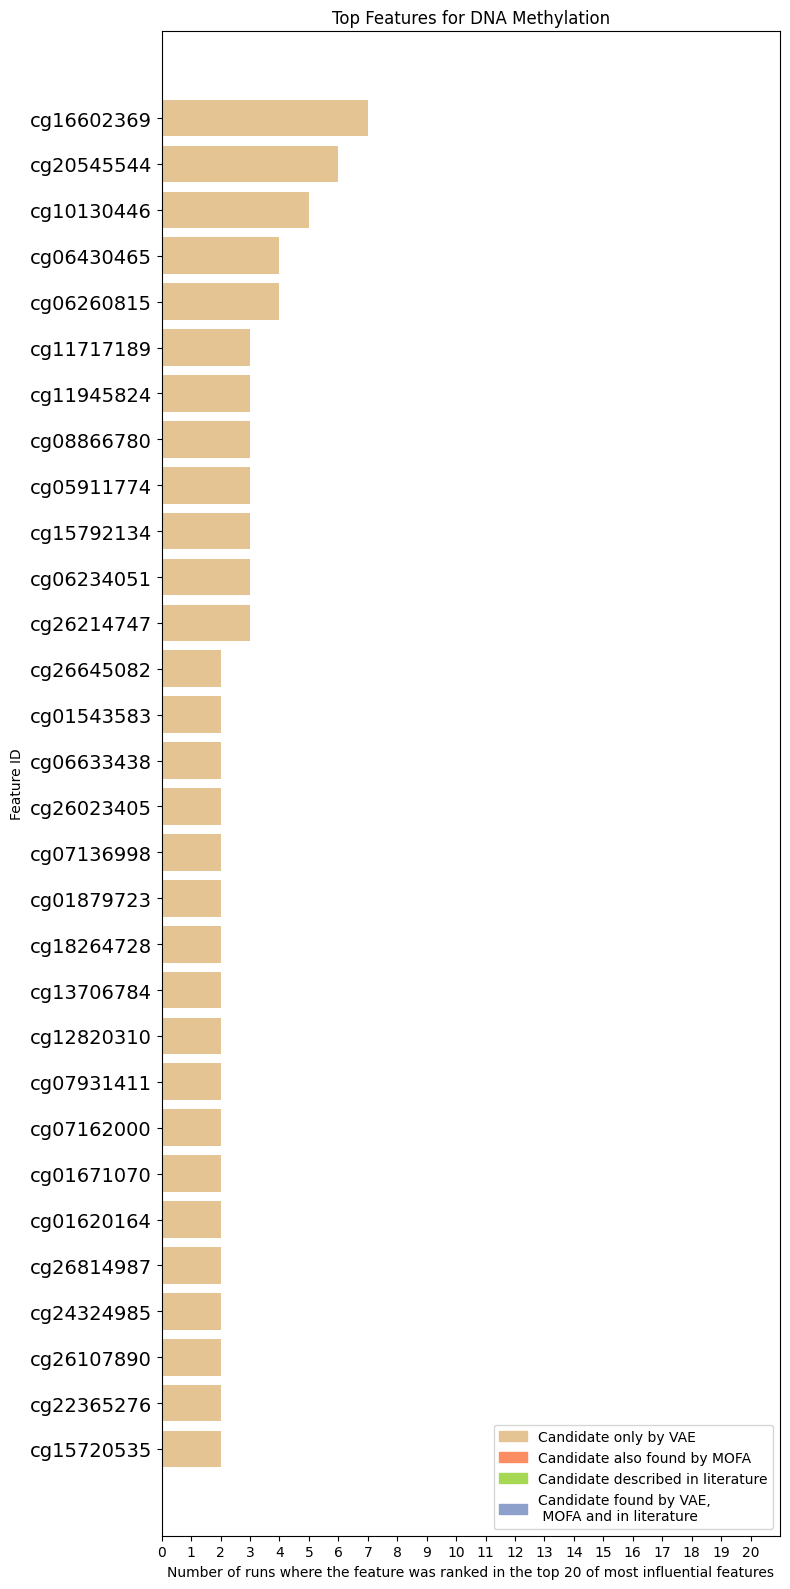

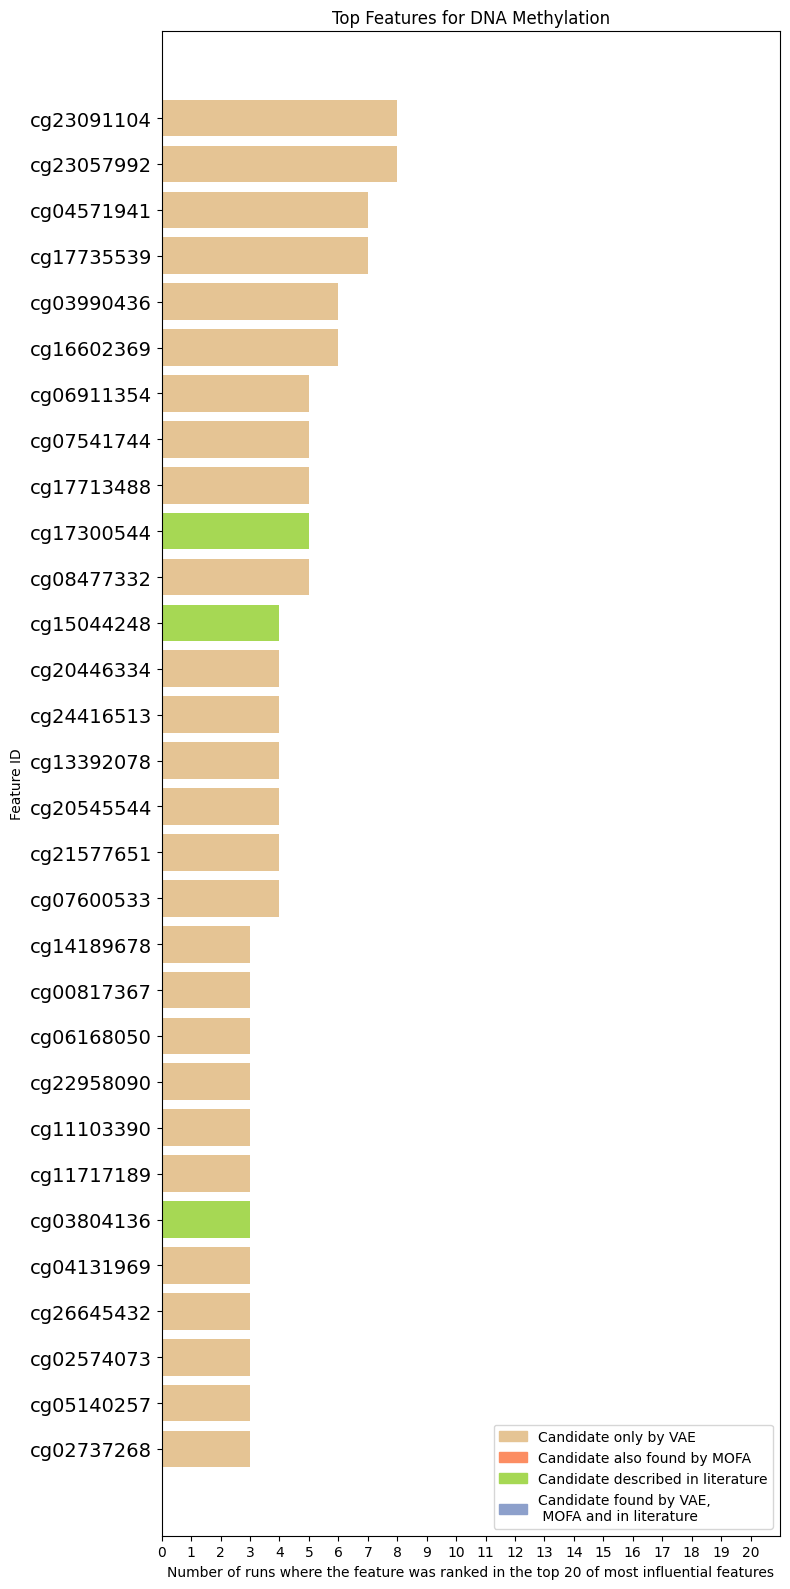

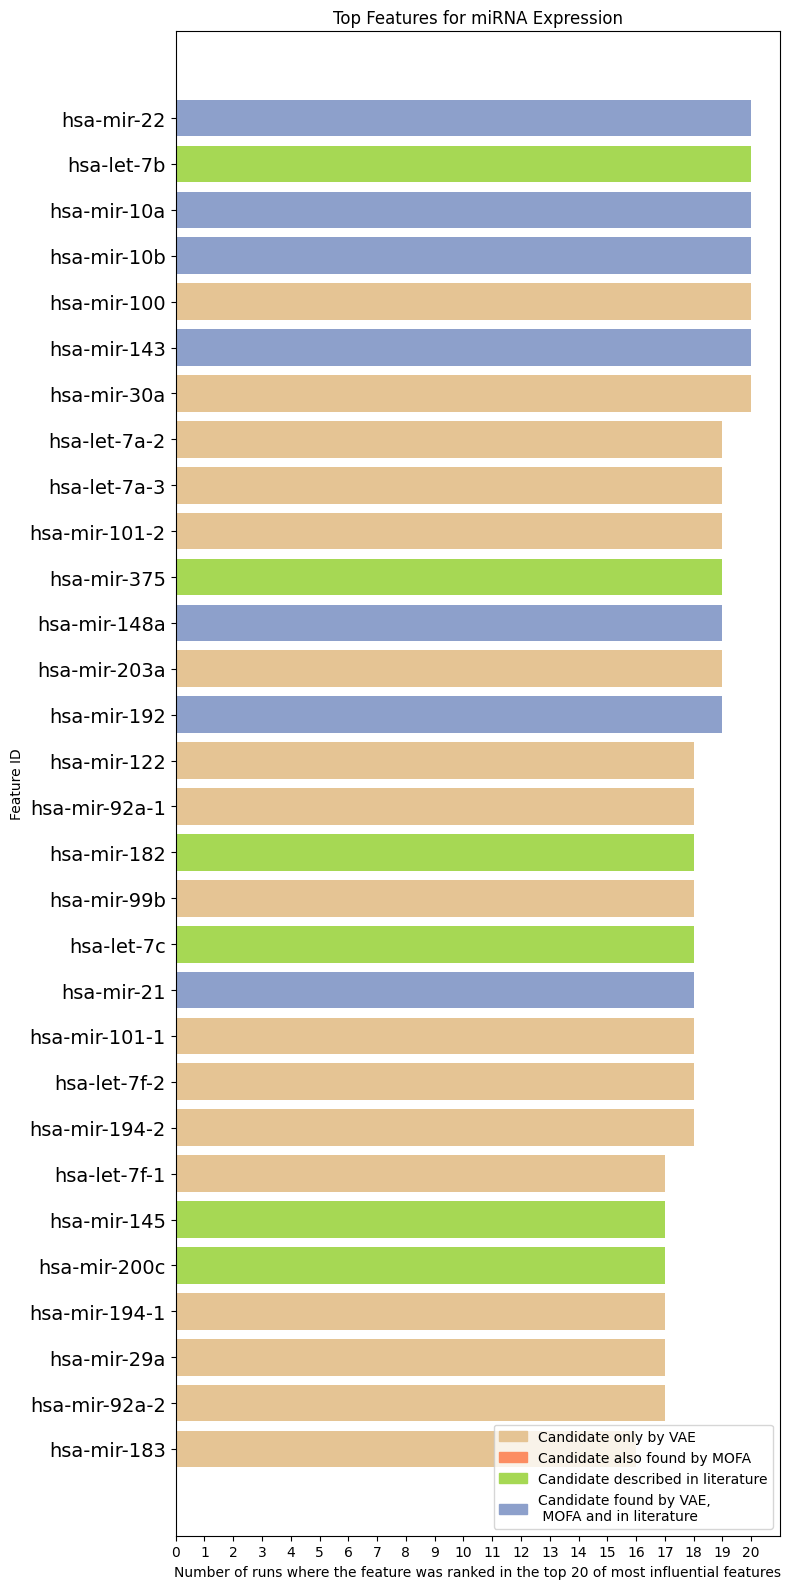

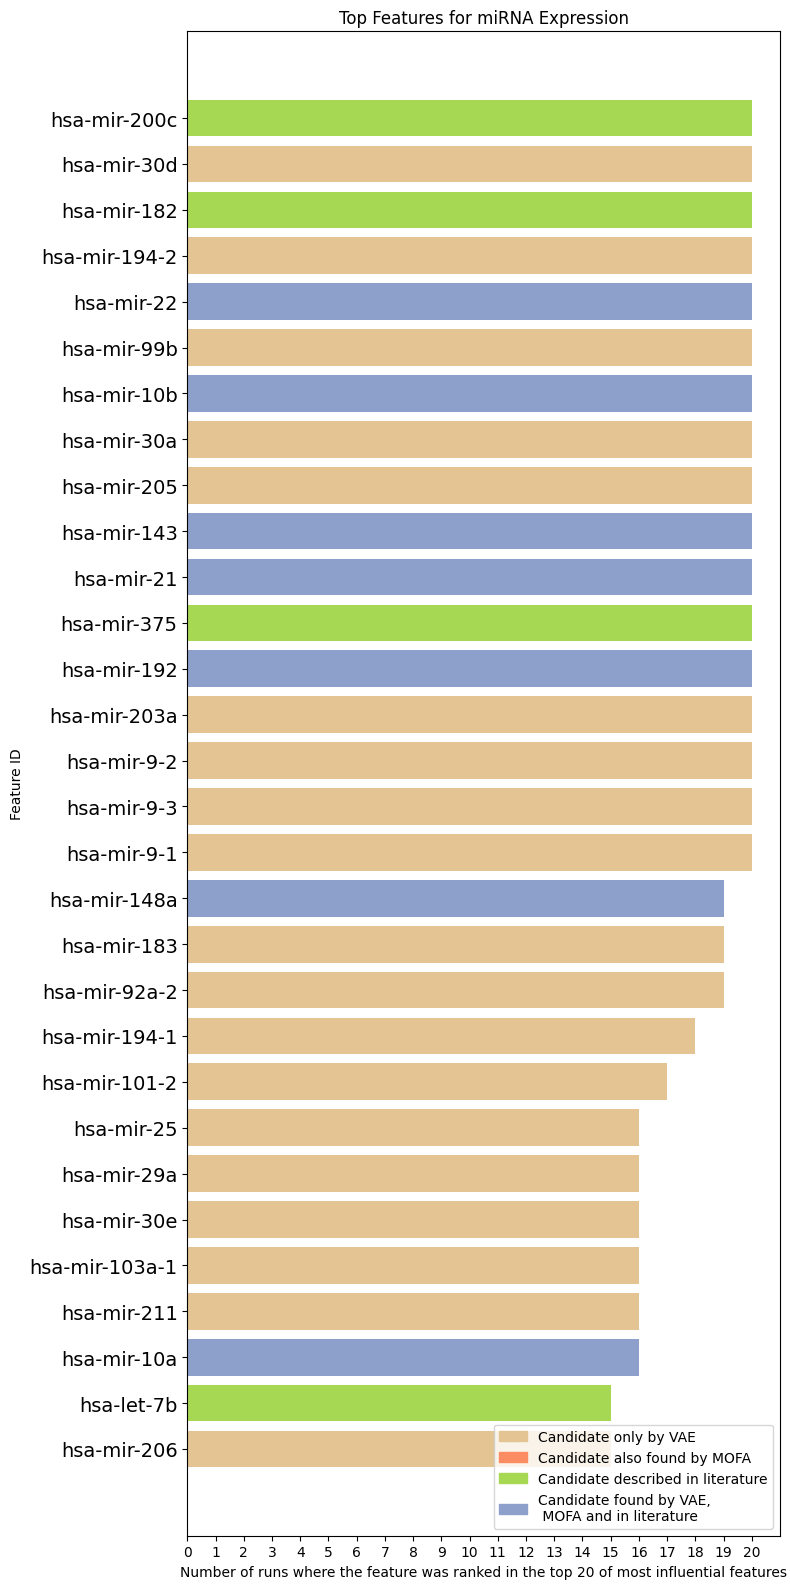

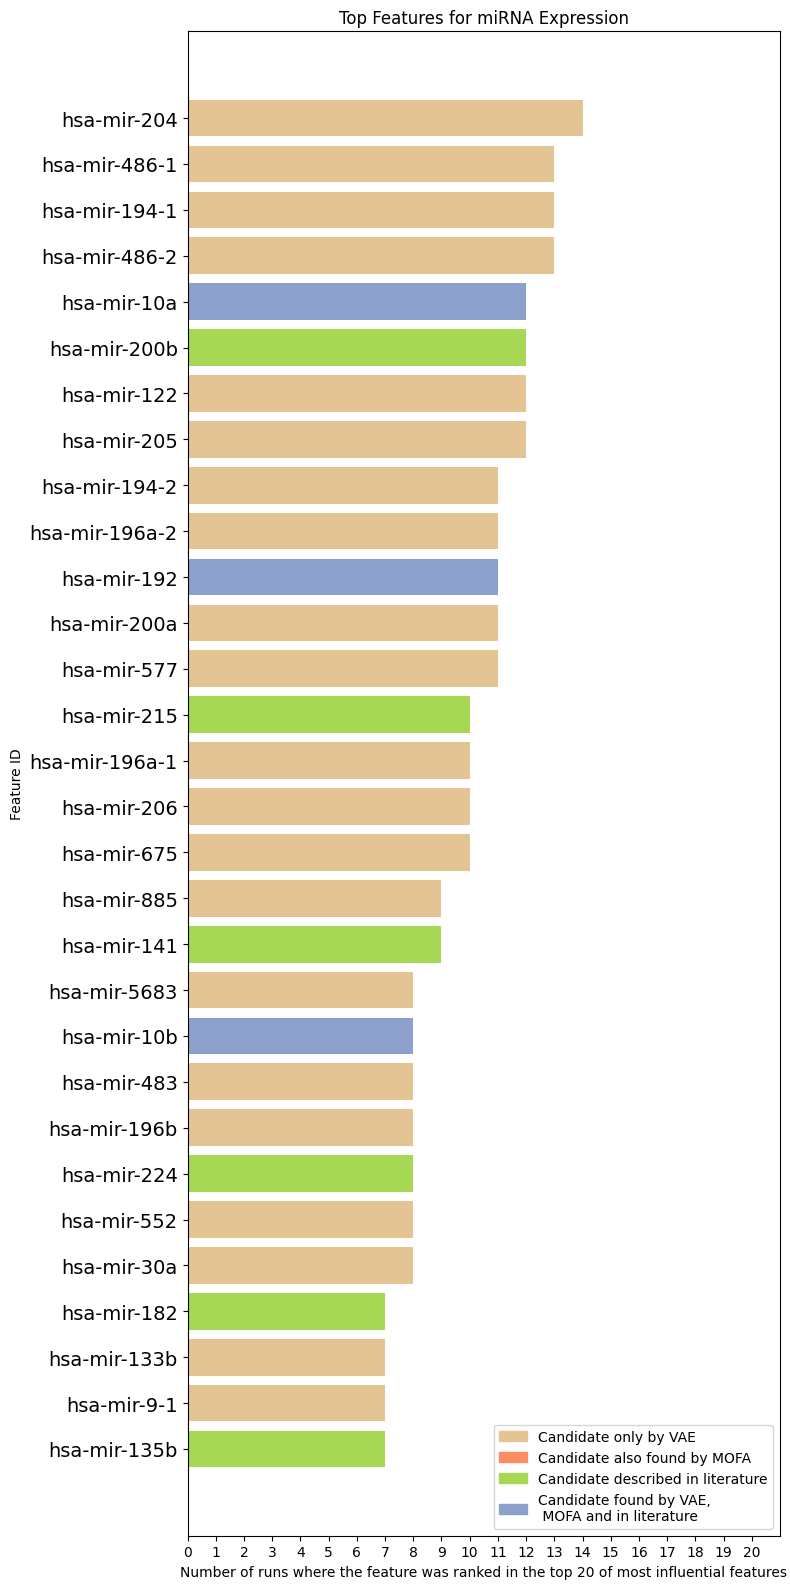

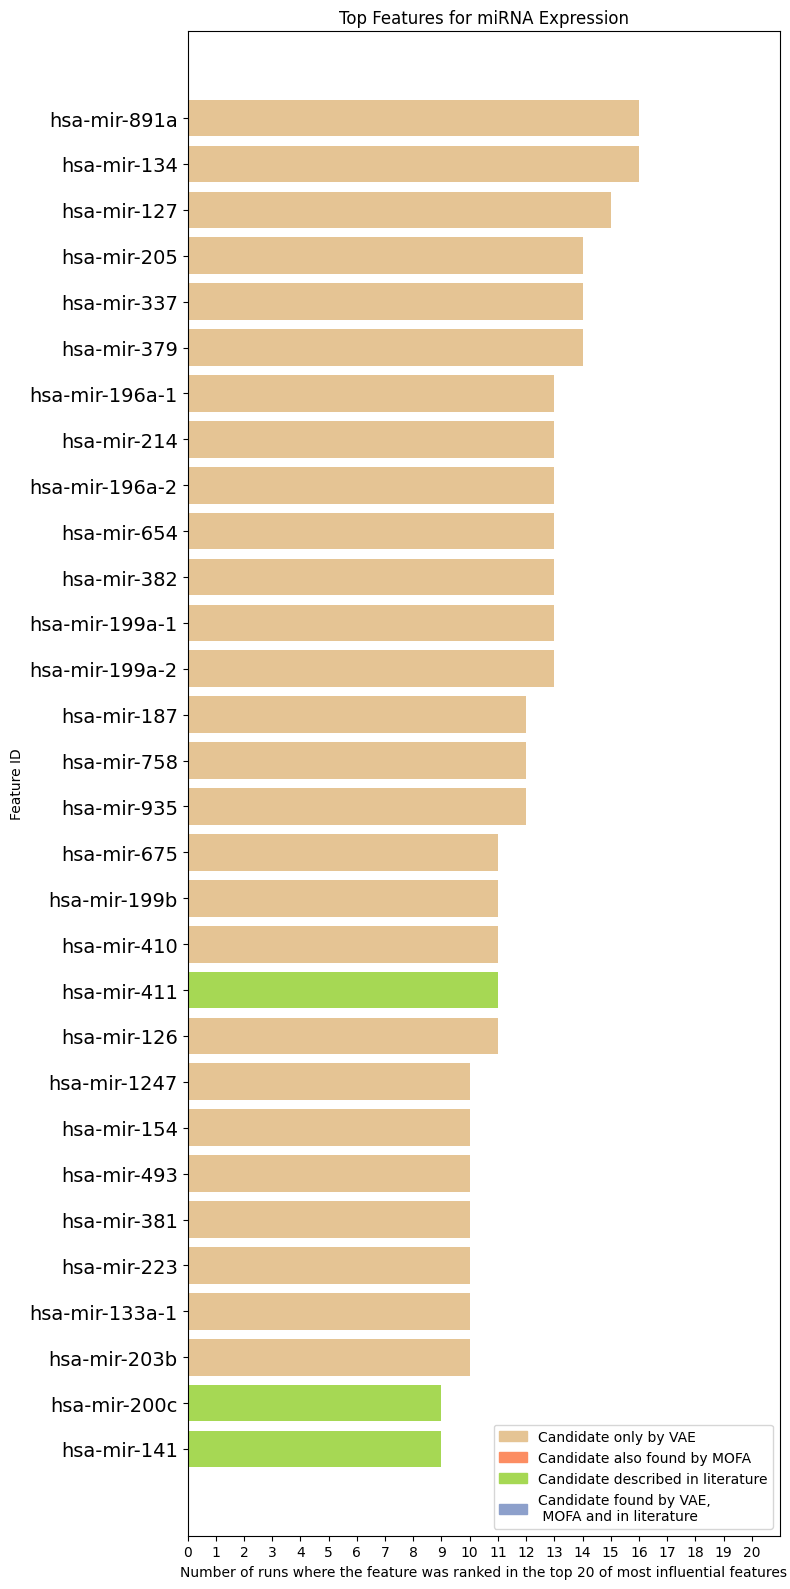

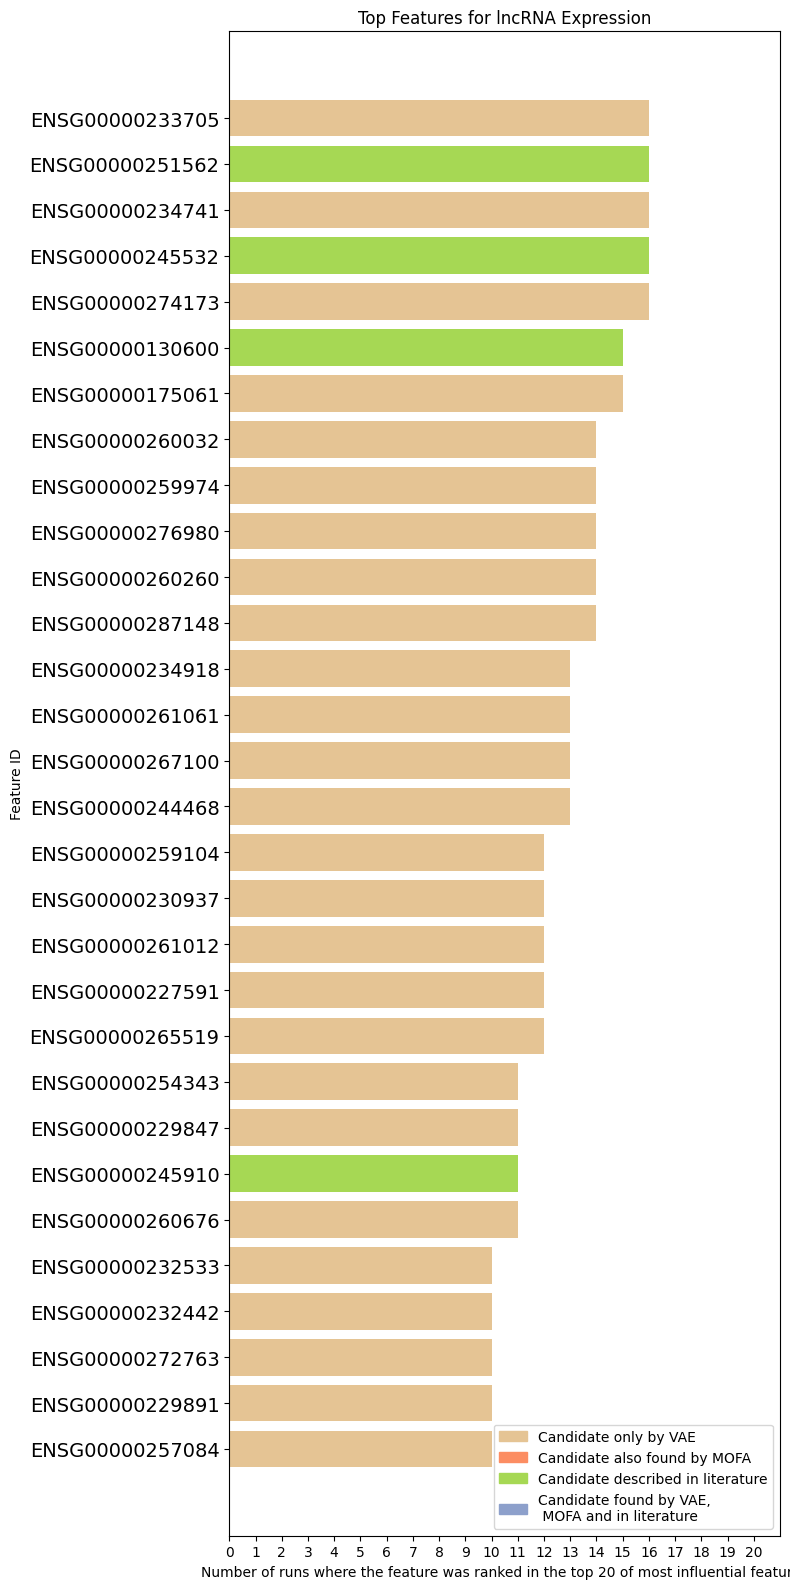

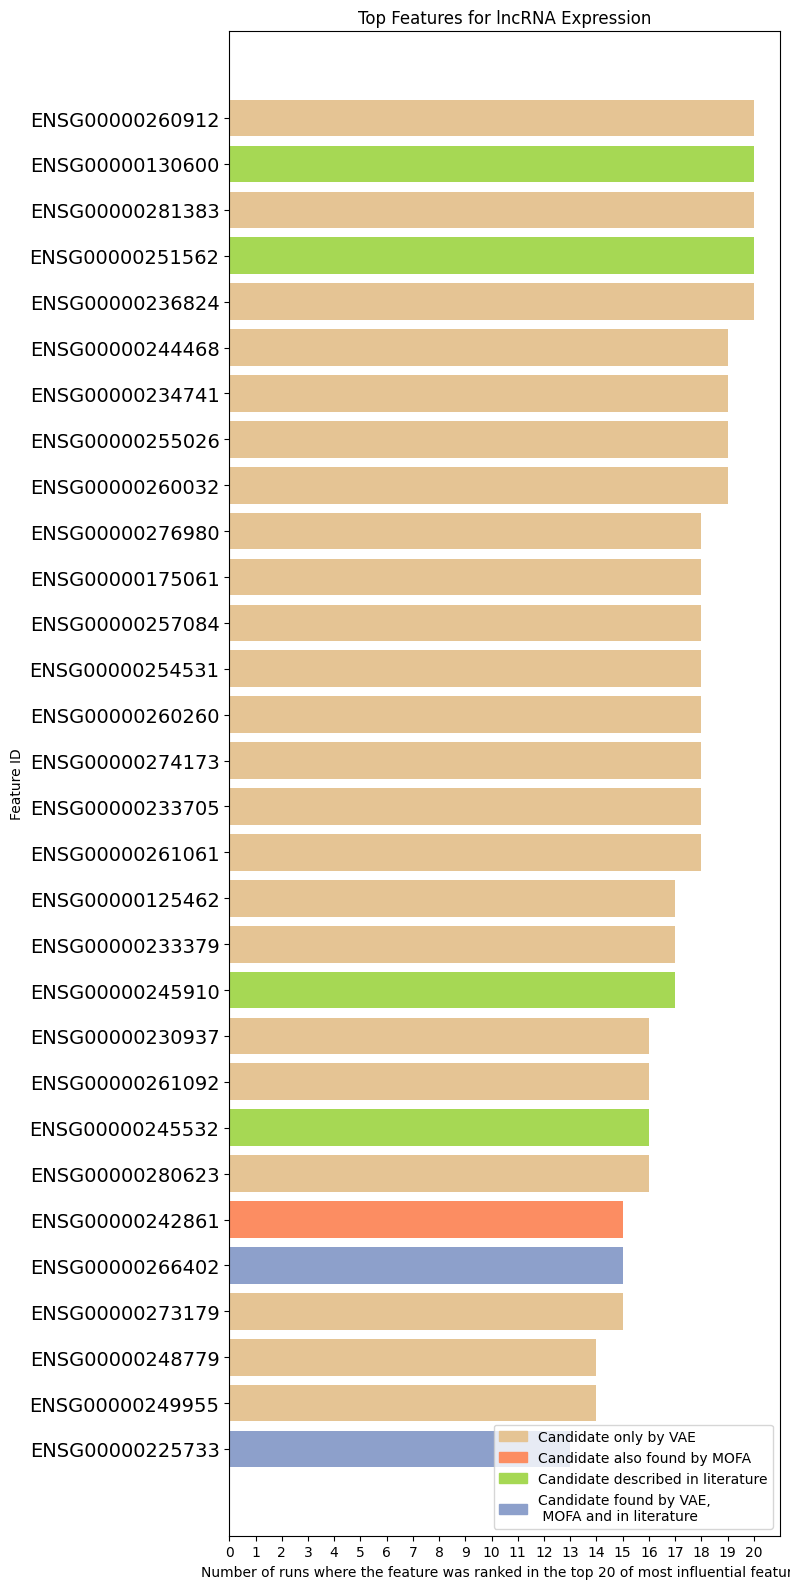

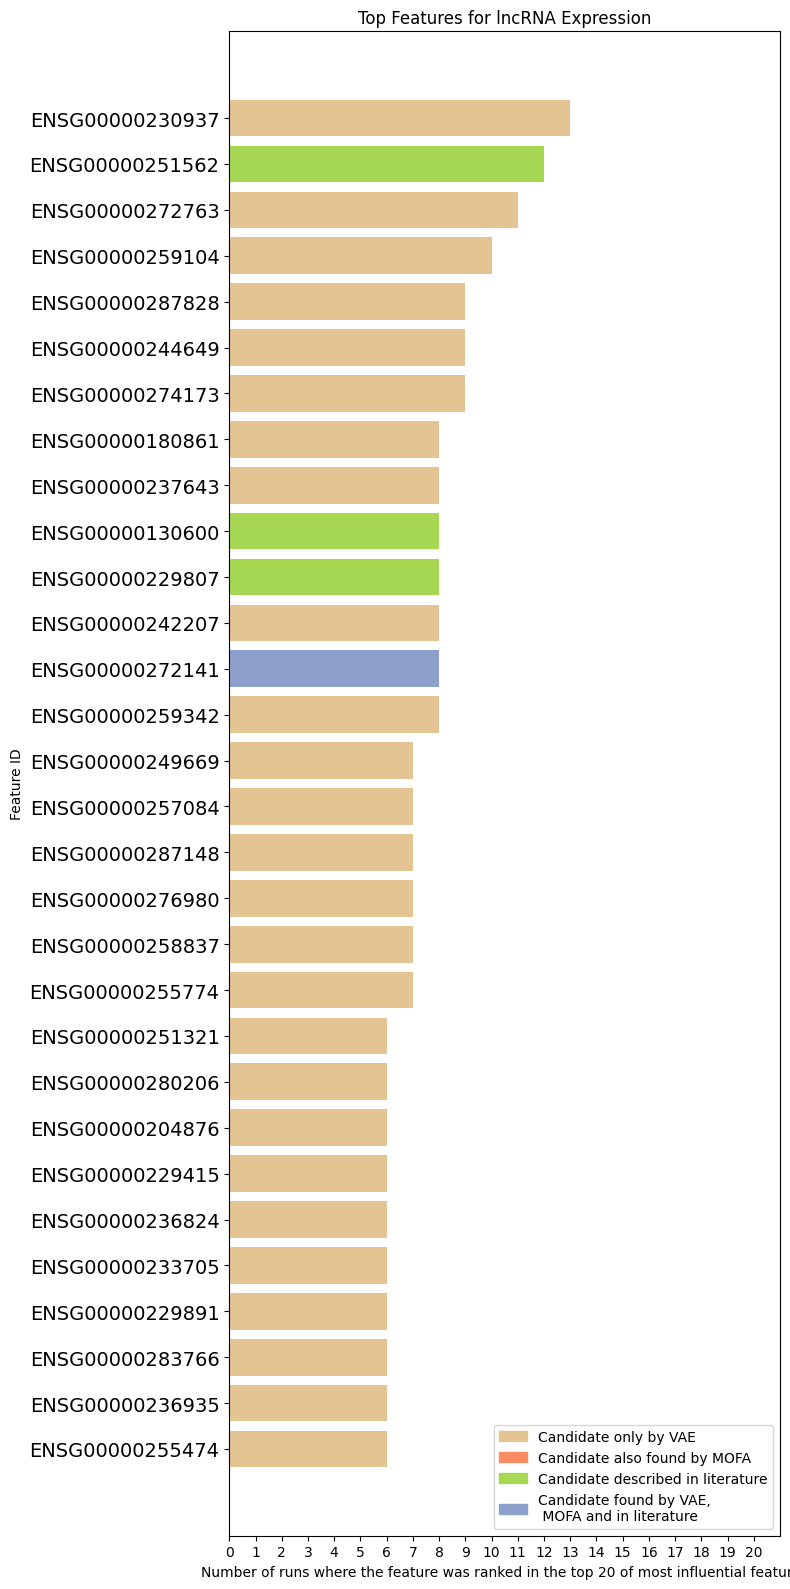

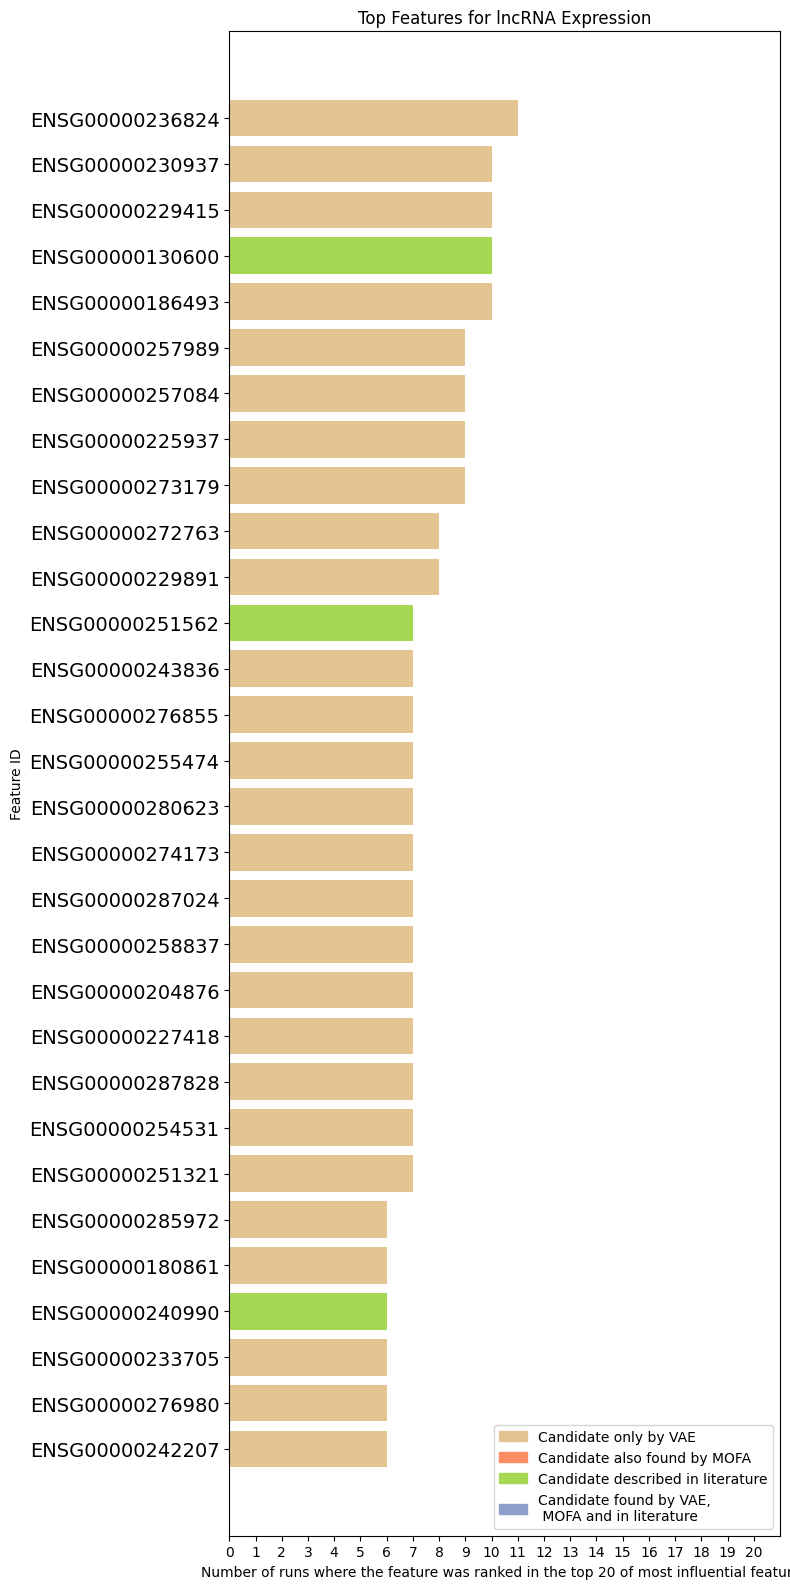

In [29]:
# store the observed features individually
for i in range(len(OMICS)):
    # write the coad normal plot
    fig, ax = plt.subplots()
    fig.set_figheight(16)
    fig.set_figwidth(8)
    ax = set_subplot(coad_normal_omic_features, ax, OMICS[i], 30, '_coad_normal_shap_values')
    plt.tight_layout()
    plt.savefig(f'Shap_values/{OMICS[i]}_coad_normal_shap_values_plot.png')
    plt.show()
    # write the all cancer plot
    fig, ax = plt.subplots()
    fig.set_figheight(16)
    fig.set_figwidth(8)
    ax = set_subplot(all_cancer_omic_features, ax, OMICS[i], 30, '_all_cancer_shap_values_plot')
    plt.tight_layout()
    plt.savefig(f'Shap_values/{OMICS[i]}_all_cancer_shap_values_plot.png')
    plt.show()
    # write the coad normal plot
    fig, ax = plt.subplots()
    fig.set_figheight(16)
    fig.set_figwidth(8)
    ax = set_subplot(log_coad_normal_omic_features, ax, OMICS[i], 30, '_log_coad_normal_shap_values')
    plt.tight_layout()
    plt.savefig(f'Shap_values/{OMICS[i]}_log_coad_normal_shap_values_plot.png')
    plt.show()
    # write the all cancer plot
    fig, ax = plt.subplots()
    fig.set_figheight(16)
    fig.set_figwidth(8)
    ax = set_subplot(log_all_cancer_omic_features, ax, OMICS[i], 30, '_log_all_cancer_shap_values_plot')
    plt.tight_layout()
    plt.savefig(f'Shap_values/{OMICS[i]}_log_all_cancer_shap_values_plot.png')
    plt.show()